In [ ]:
from vis import basic_plot
import numpy as np
%load_ext autoreload
%autoreload 2
from base import HCP_subject
from analysis import Analysis
import pandas as pd
import matplotlib.pyplot as plt


mask = pd.read_csv('./auditory_A1_LBelt.csv')
mask = np.array(mask['mask']).astype(bool)

In [52]:
saved_gf = np.load('./saved_model_params/gf_A1_LBelt.npz')
css = np.load('./saved_model_params/css_A1_LBelt.npz')
dn = np.load('./saved_model_params/run 2/DN_A1_LBelt.npz')

In [ ]:
my_sub=HCP_subject('999999','movie','/tank/oso210/projects/Tonotopy_2021/config.yml')

In [ ]:
my_sub.prep_data()
my_sub.import_data()

In [ ]:
my_analysis=Analysis(my_sub)

In [30]:
test_stim=PRFStimulus1D(my_analysis.sub.dm_test[fold],my_analysis.frequencies,TR=my_analysis.TR, task_lengths=[818])


### DN Predictions for 1 fold only

In [15]:
# Run 2 params
max_center_size = np.max(gf.iterative_search_params[:, 1])
min_center_size = np.min(gf.iterative_search_params[:, 1])

surround_amplitude_grid = np.array(np.linspace(0, 1, 11), dtype='float32')

surround_size_grid = np.array(np.linspace(1, 5, 11) * max_center_size, dtype='float32')

neural_baseline_grid = np.array(np.linspace(0, 1, 11), dtype='float32')

surround_baseline_grid = np.array(np.linspace(0, 1, 11), dtype='float32')

In [ ]:
Norm_extender.grid_fit(surround_amplitude_grid,surround_size_grid,neural_baseline_grid,surround_baseline_grid)

In [ ]:
from scipy.optimize import LinearConstraint, NonlinearConstraint
inf = np.inf

constraints_norm=[]
def positive_centre_prf_norm(x):
        return (x[2]+x[6])/(x[4]+x[7]) - x[6]/x[7]
        
constraints_norm.append(NonlinearConstraint(positive_centre_prf_norm,
                                                    lb=0,
                                                    ub=+inf))

A_ssc_norm = np.array([[0,-1,0,0,0,1,0,0]])

Normbounds=((my_analysis.mu_min,my_analysis.mu_max),(my_analysis.sigma_min,my_analysis.sigma_max),(None,None),(None,None),(.05,3),(my_analysis.sigma_min,my_analysis.sigma_max),(0,100),(0,100))
constraints_norm.append(LinearConstraint(A_ssc_norm,lb=0,ub=+inf))
Norm_extender.rsq_mask=mask
Norm_extender.iterative_fit(rsq_threshold=0,verbose=True,constraints=constraints_norm,bounds=Normbounds)

In [18]:
Norm_extender.crossvalidate_fit(test_data=my_analysis.sub.data_test[fold].T,
                        test_stimulus=test_stim)

## Overfitting??

There seem to be more than 15% drop in the explained variance(see the average R2).


In [69]:
#highest r2 in the test data set
print('Highest r2 in the train data is: ', Norm_extender.iterative_search_params[mask][:,-1][0])
print('Highest r2 in the test data is: ', Norm_extender.CV_rsq[mask][0])
print("Average R2 for train and test data respectively: ", np.mean(Norm_extender.iterative_search_params[mask][:,-1]), np.mean(Norm_extender.CV_rsq[mask]))

Highest r2 in the train data is:  0.5233899421252115
Highest r2 in the test data is:  0.3165589817631196
Average R2 for train and test data respectively:  0.4847311363991649 0.2789955052772137


### Plot the test r2 for the test data

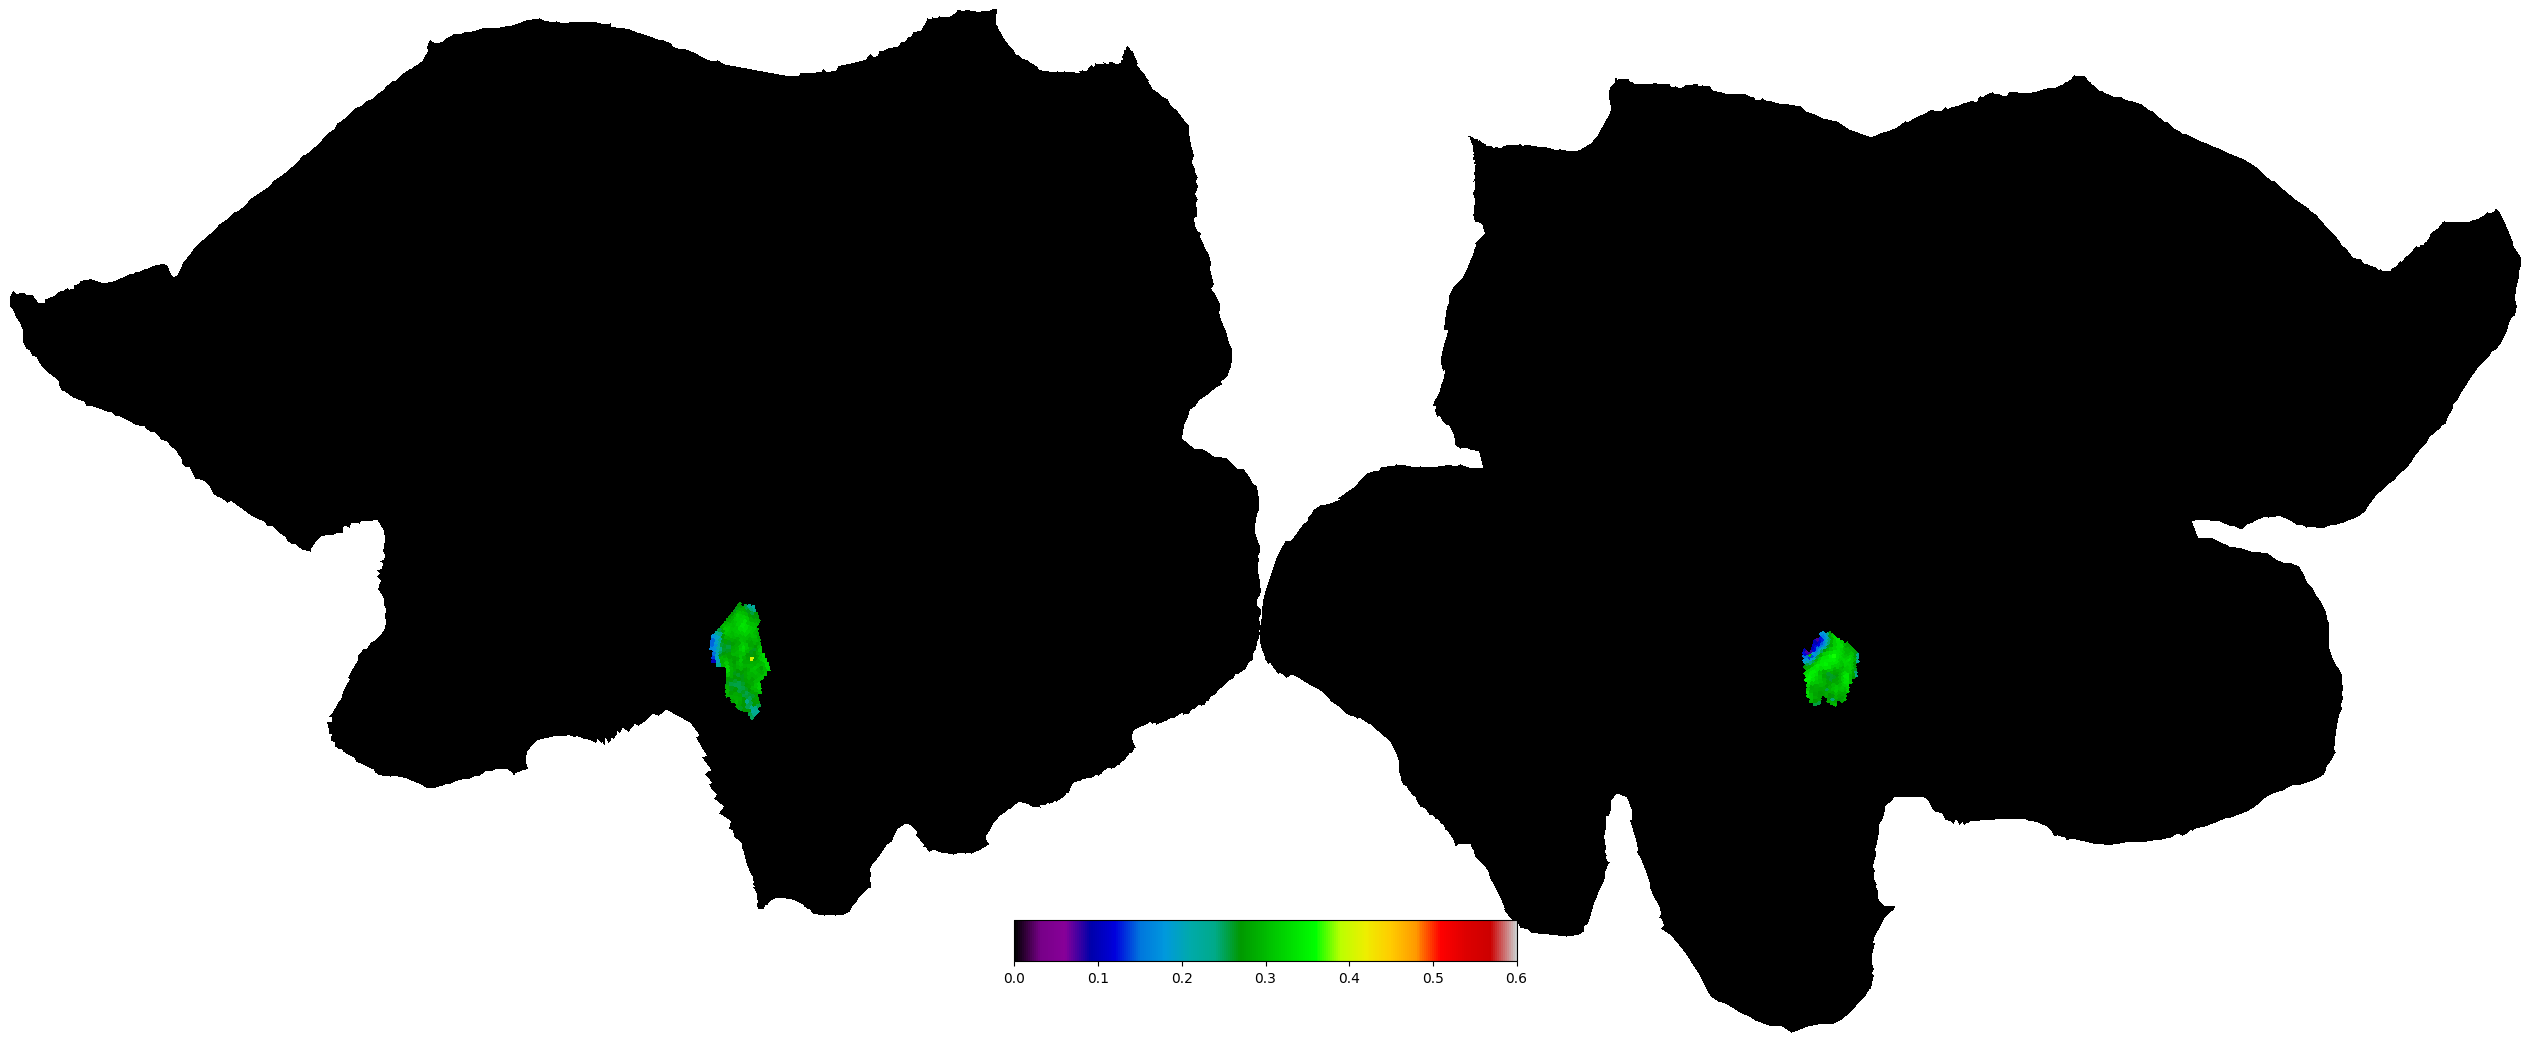

In [70]:
bp=basic_plot(Norm_extender.CV_rsq, colorbar = True, vmax=.6,cmap='nipy_spectral')

In [21]:
np.savez_compressed('./saved_model_params/DN_A1_LBelt', gridsearch_params = Norm_extender.gridsearch_params, iterative_search_params = Norm_extender.iterative_search_params, rsq_mask=Norm_extender.rsq_mask)

### Make a timeseries for the target and predicted of a voxel in the auditory core

(626, 818)
(626, 818)
(626, 818)


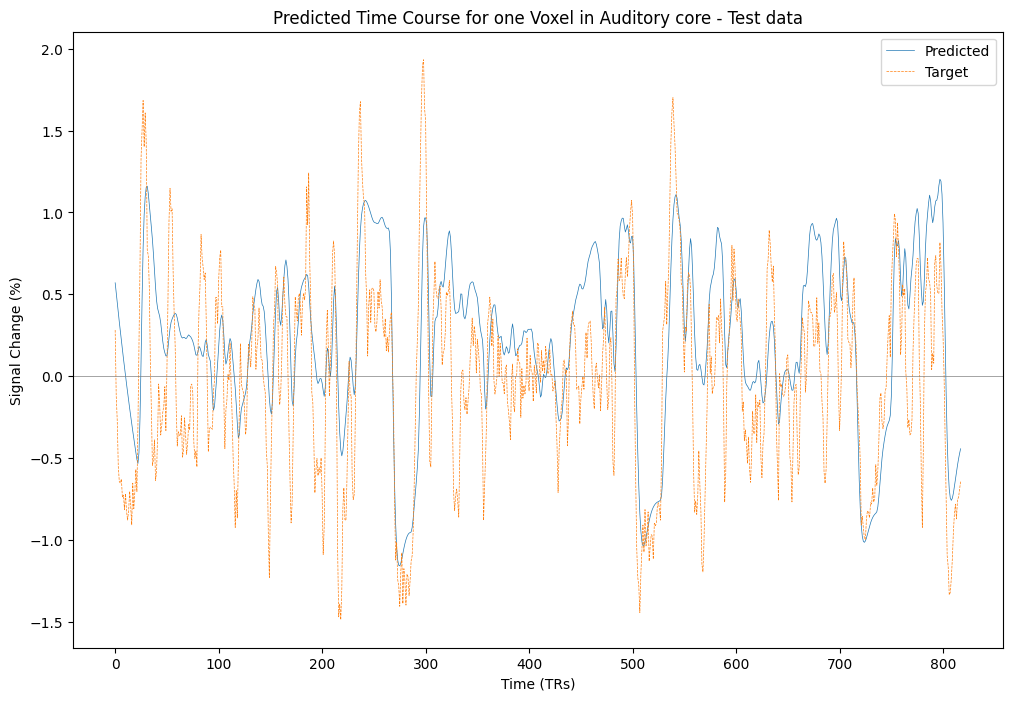

In [40]:
nm=Norm_Iso1DGaussianModel(test_stim,normalise_RFs=False,filter_predictions=True,filter_type='sg',filter_params=my_analysis.fparams)


nm.stimulus = test_stim
target_time_series = my_analysis.sub.data_test[fold].T[Norm_extender.rsq_mask]
predicted_time_series = []
print(target_time_series.shape)
params = Norm_extender.iterative_search_params[Norm_extender.rsq_mask]
for i in range(params.shape[0]):  # for each voxel in the mask
    voxel_params = params[i]
    voxel_prediction = nm.return_prediction(*voxel_params)
    predicted_time_series.append(voxel_prediction.flatten())


predicted_time_series = np.array(predicted_time_series)

print(target_time_series.shape)
print(predicted_time_series.shape)

#plotting the time course for the first voxel
plt.figure(figsize=(12, 8))
plt.plot(predicted_time_series[0], label="Predicted", linewidth=0.5)
plt.plot(target_time_series[0], label='Target', linewidth=0.5, linestyle='dashed')  

plt.title('Predicted Time Course for one Voxel in Auditory core - Test data')
plt.axhline(0, color='grey', linewidth=0.5)  

plt.xlabel('Time (TRs)')
plt.ylabel('Signal Change (%)')
plt.legend()
plt.show()

### the difference between the predicted and original time series

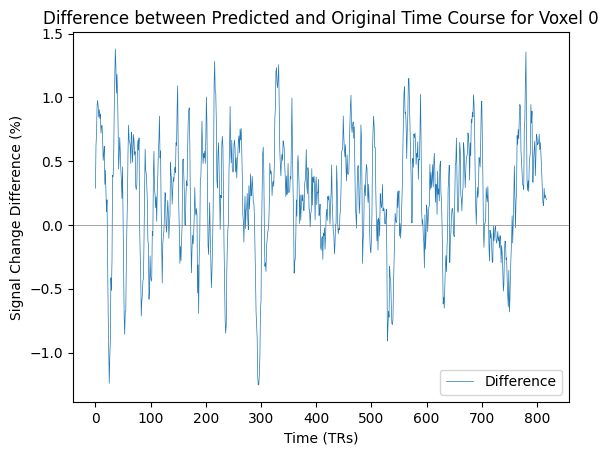

In [39]:
# the difference between the predicted and original time series
difference = predicted_time_series[0] - target_time_series[0]

plt.figure()
plt.plot(difference, label='Difference', linewidth=0.5)
plt.axhline(0, color='grey', linewidth=0.5)  
plt.title('Difference between Predicted and Original Time Course for Voxel at index 0')
plt.xlabel('Time (TRs)')
plt.ylabel('Signal Change Difference (%)')
plt.legend()
plt.show()

## Tonotopic Maps for Run 2(parameters for run 2 specified above)
### Explained Varience 

DN - GF

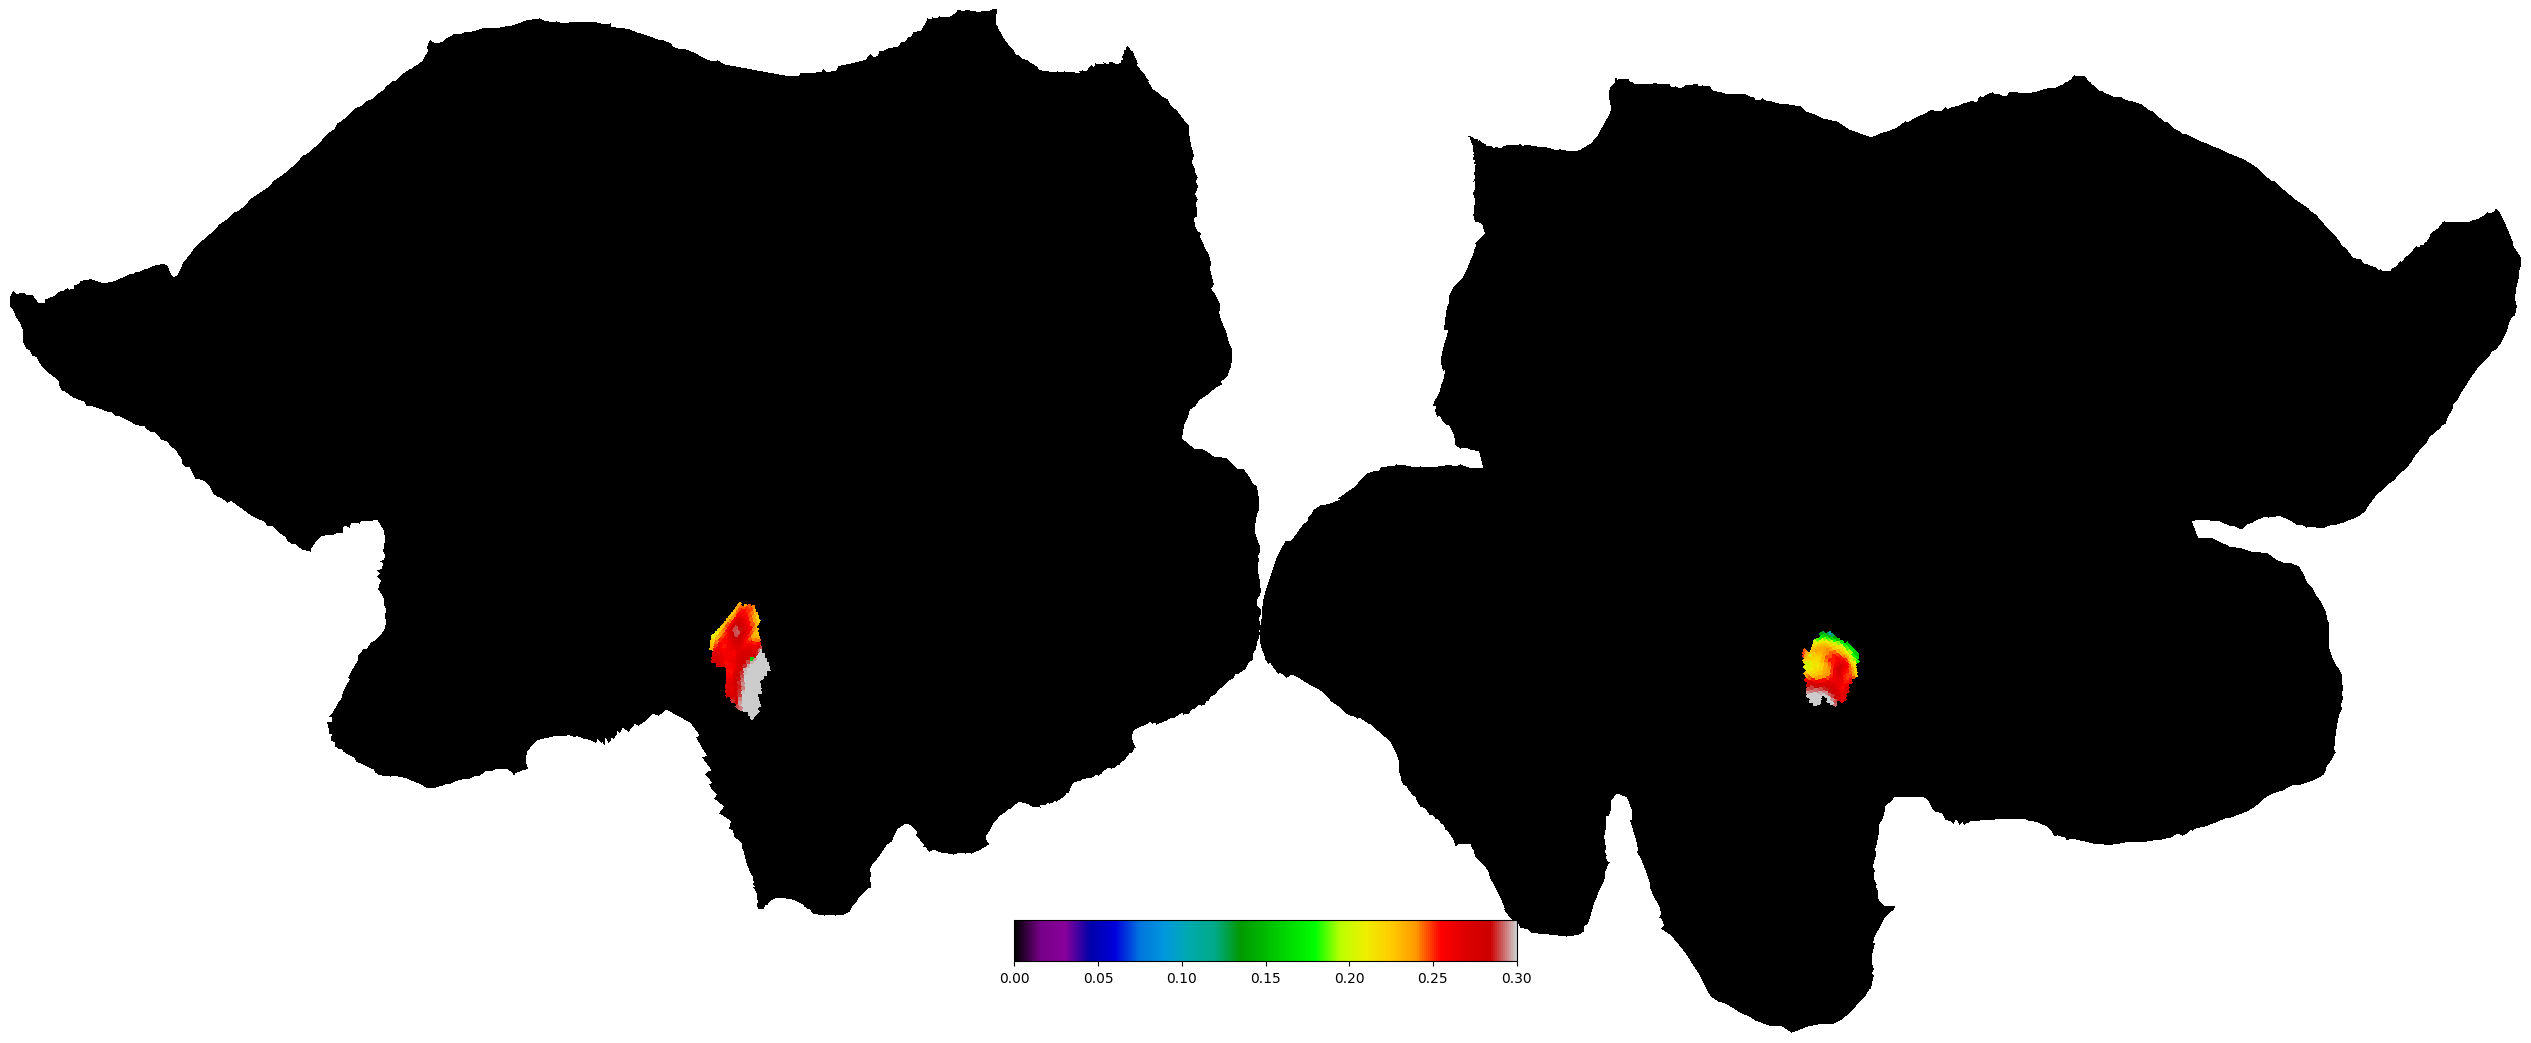

In [56]:
bp=basic_plot(dn['iterative_search_params'][:,-1]-saved_gf['iterative_search_params'][:,-1],  colorbar= True,vmax=.3,cmap='nipy_spectral')

DN - CSS

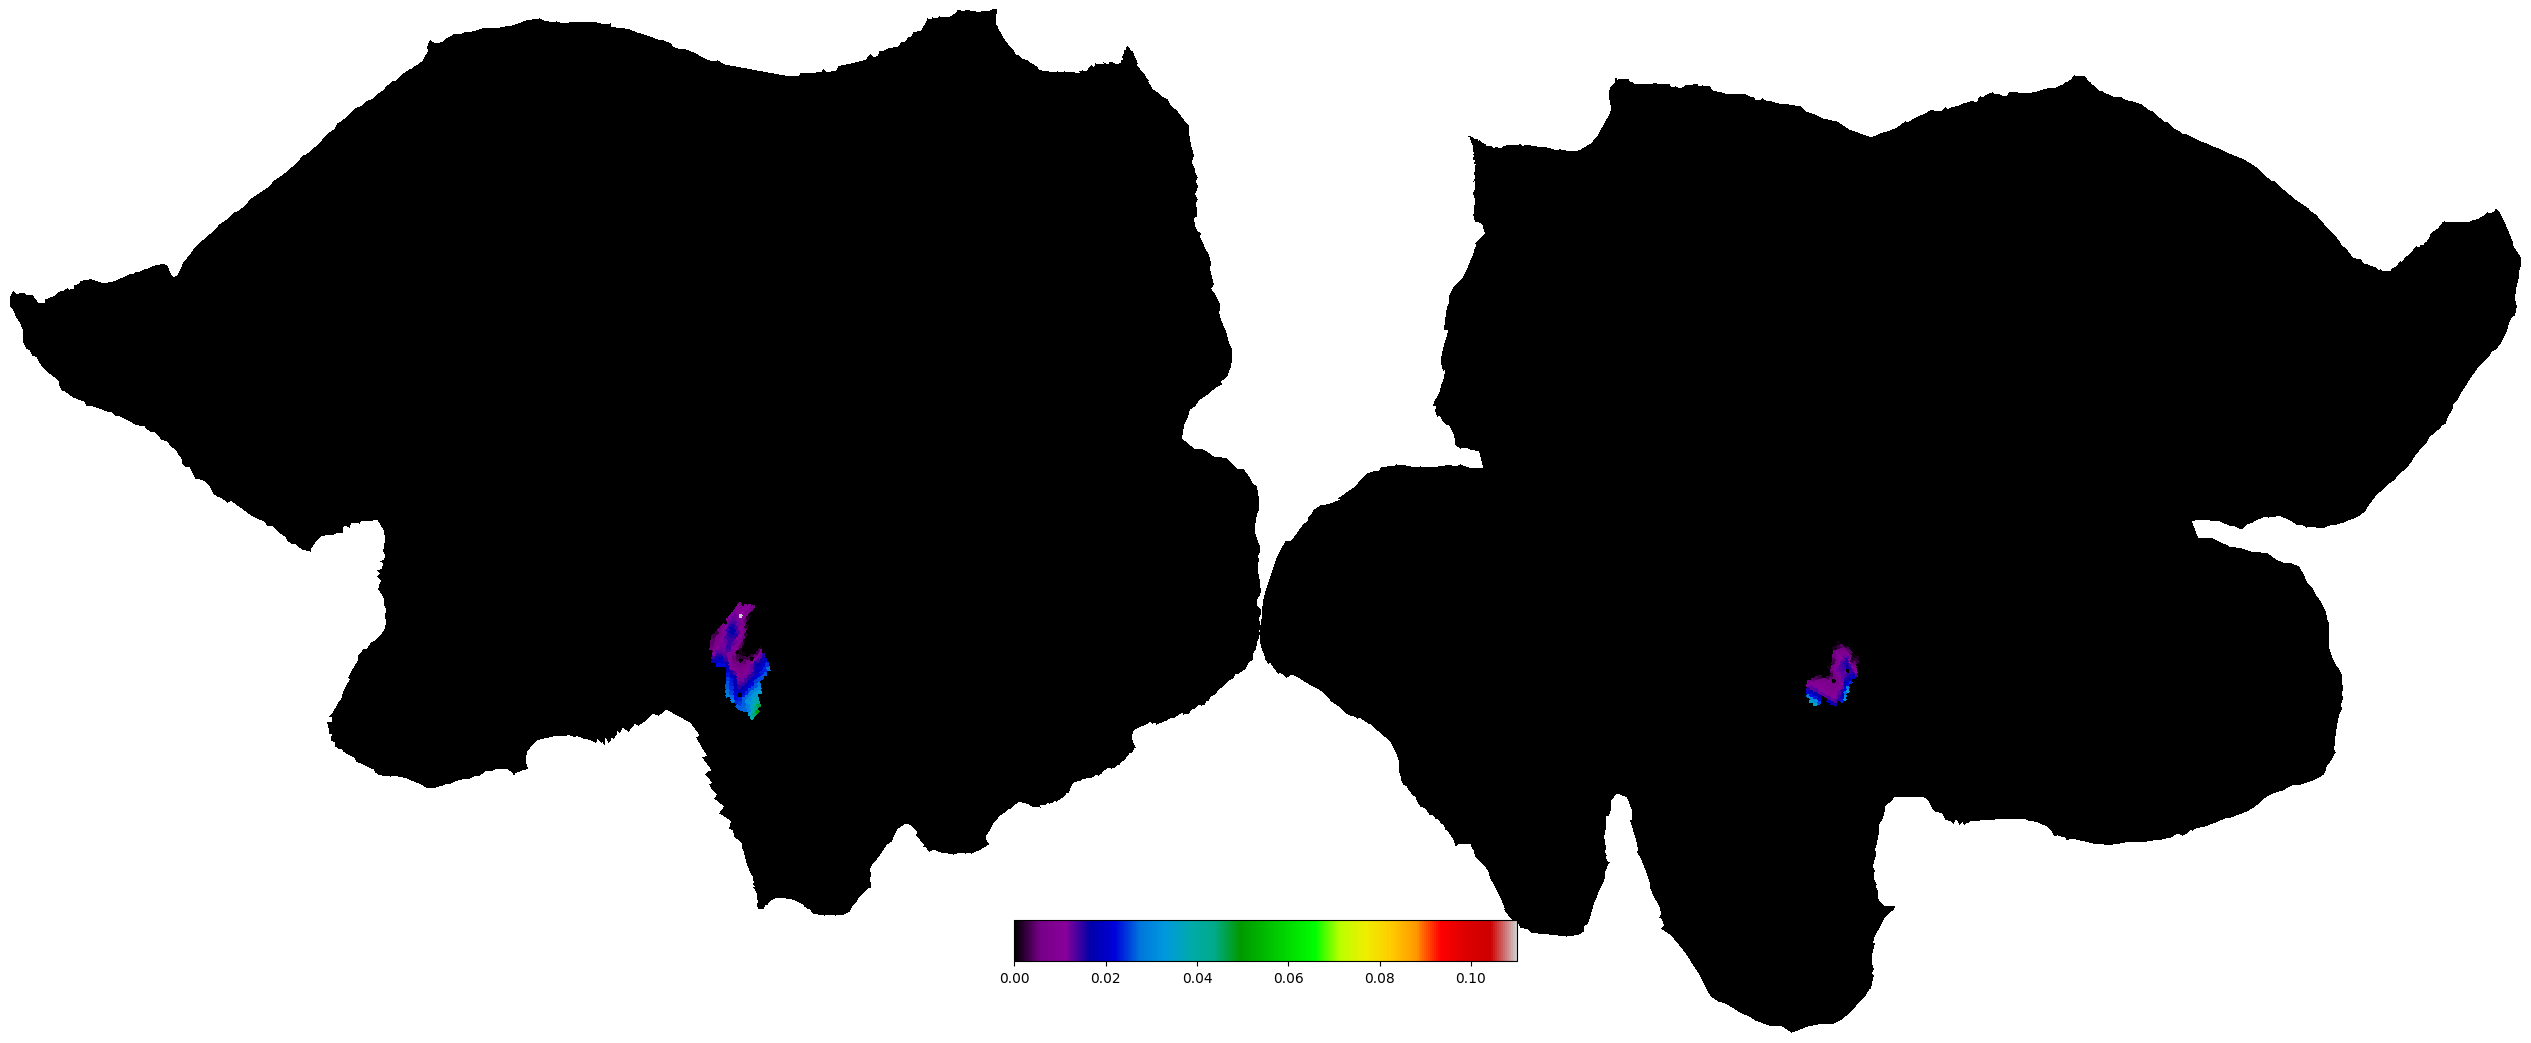

In [57]:
bp=basic_plot(dn['iterative_search_params'][:,-1]-css['iterative_search_params'][:,-1],  colorbar= True,vmax=.11,cmap='nipy_spectral')

### Css - DN - Still DN seem to be doing better.

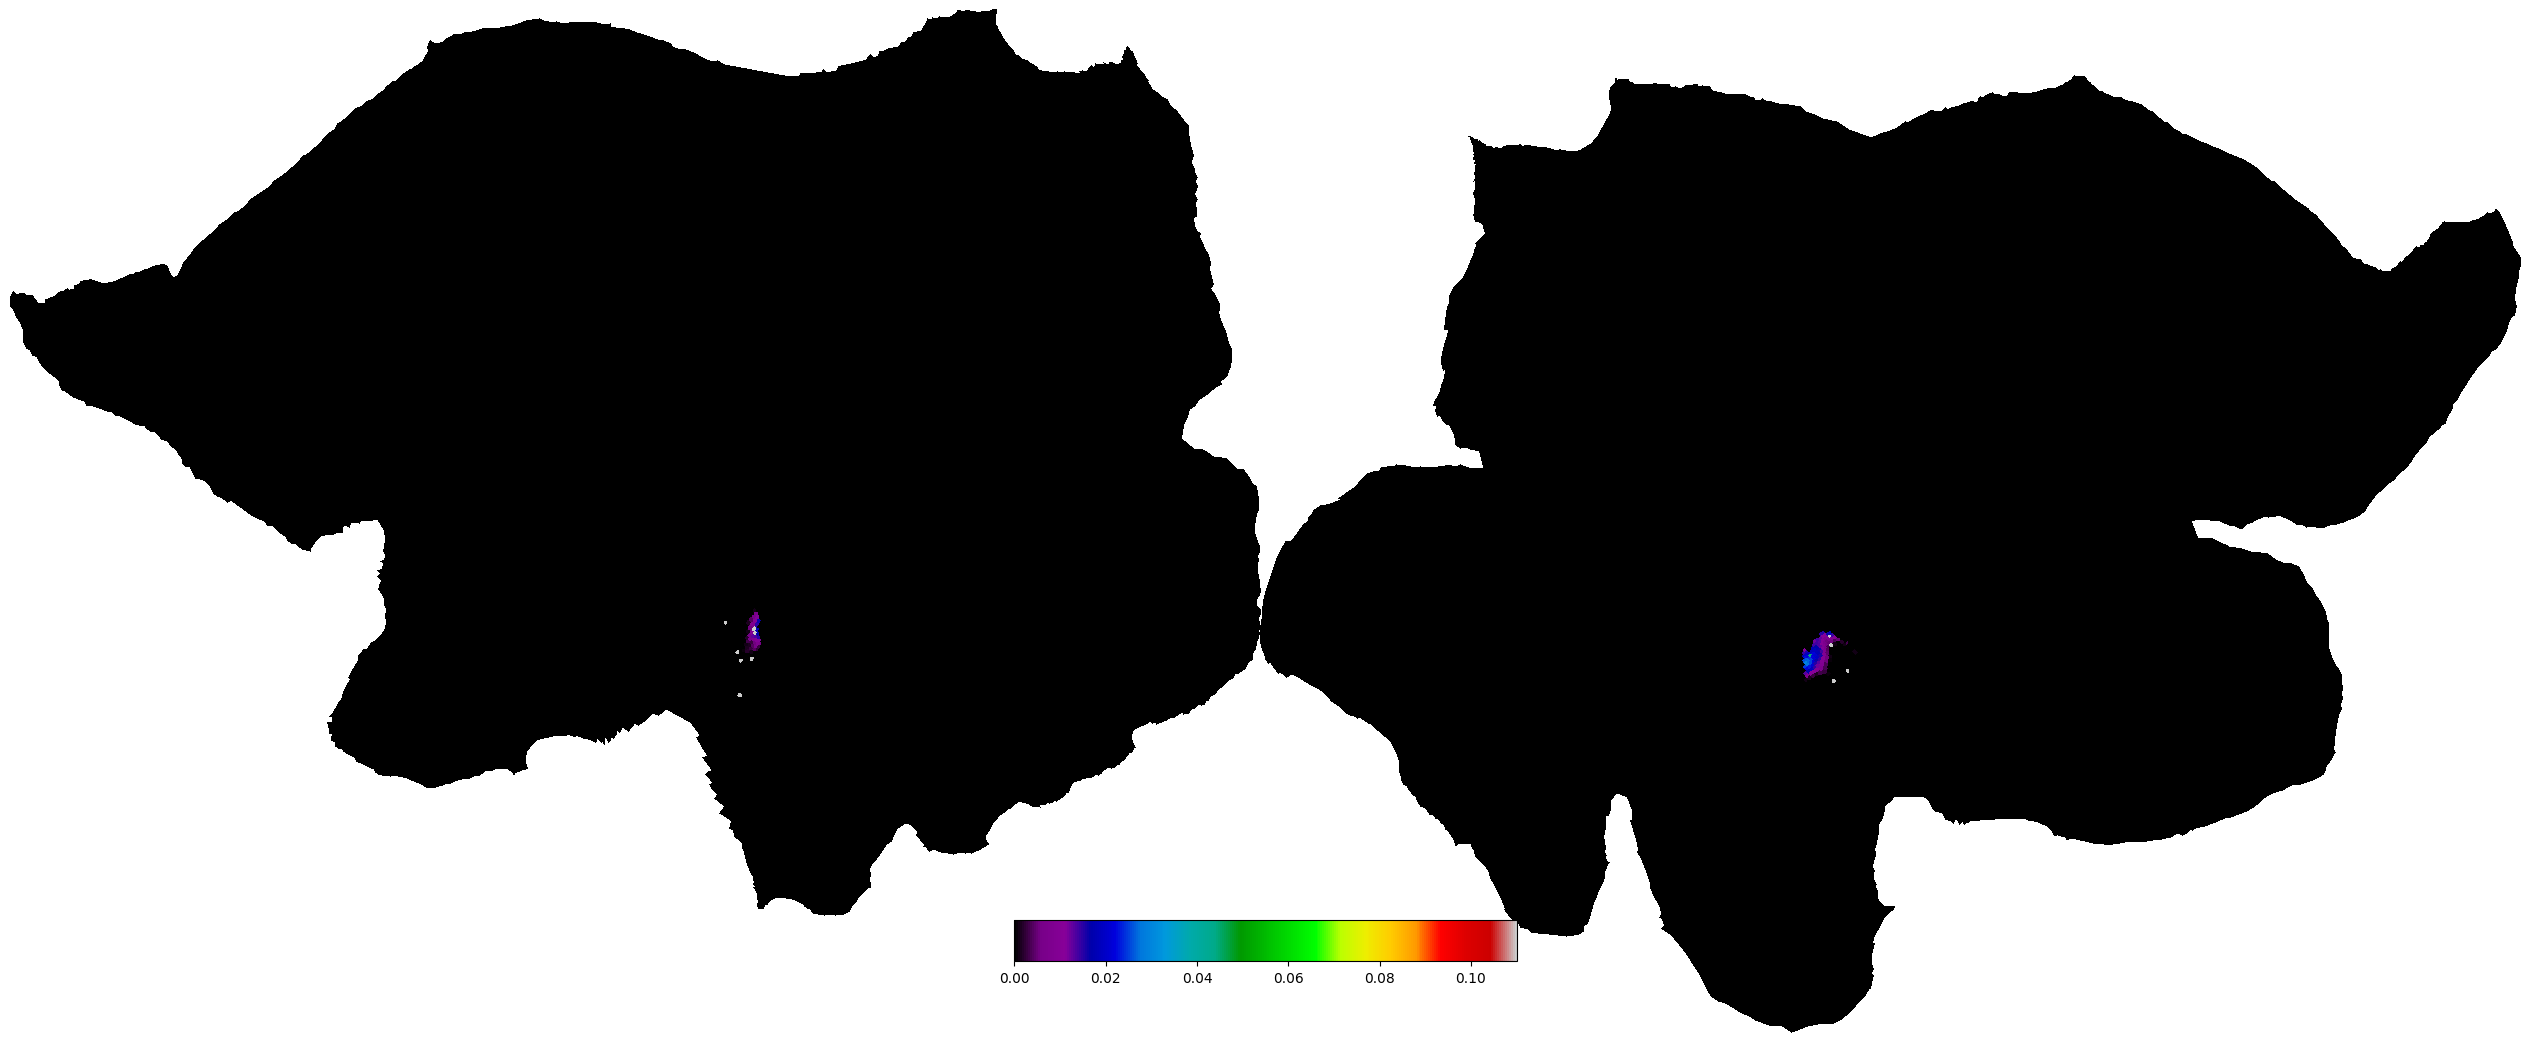

In [78]:
bp=basic_plot(css['iterative_search_params'][:,-1]-dn['iterative_search_params'][:,-1],  colorbar= True,vmax=.11,cmap='nipy_spectral')

### For the train data of the DN model.

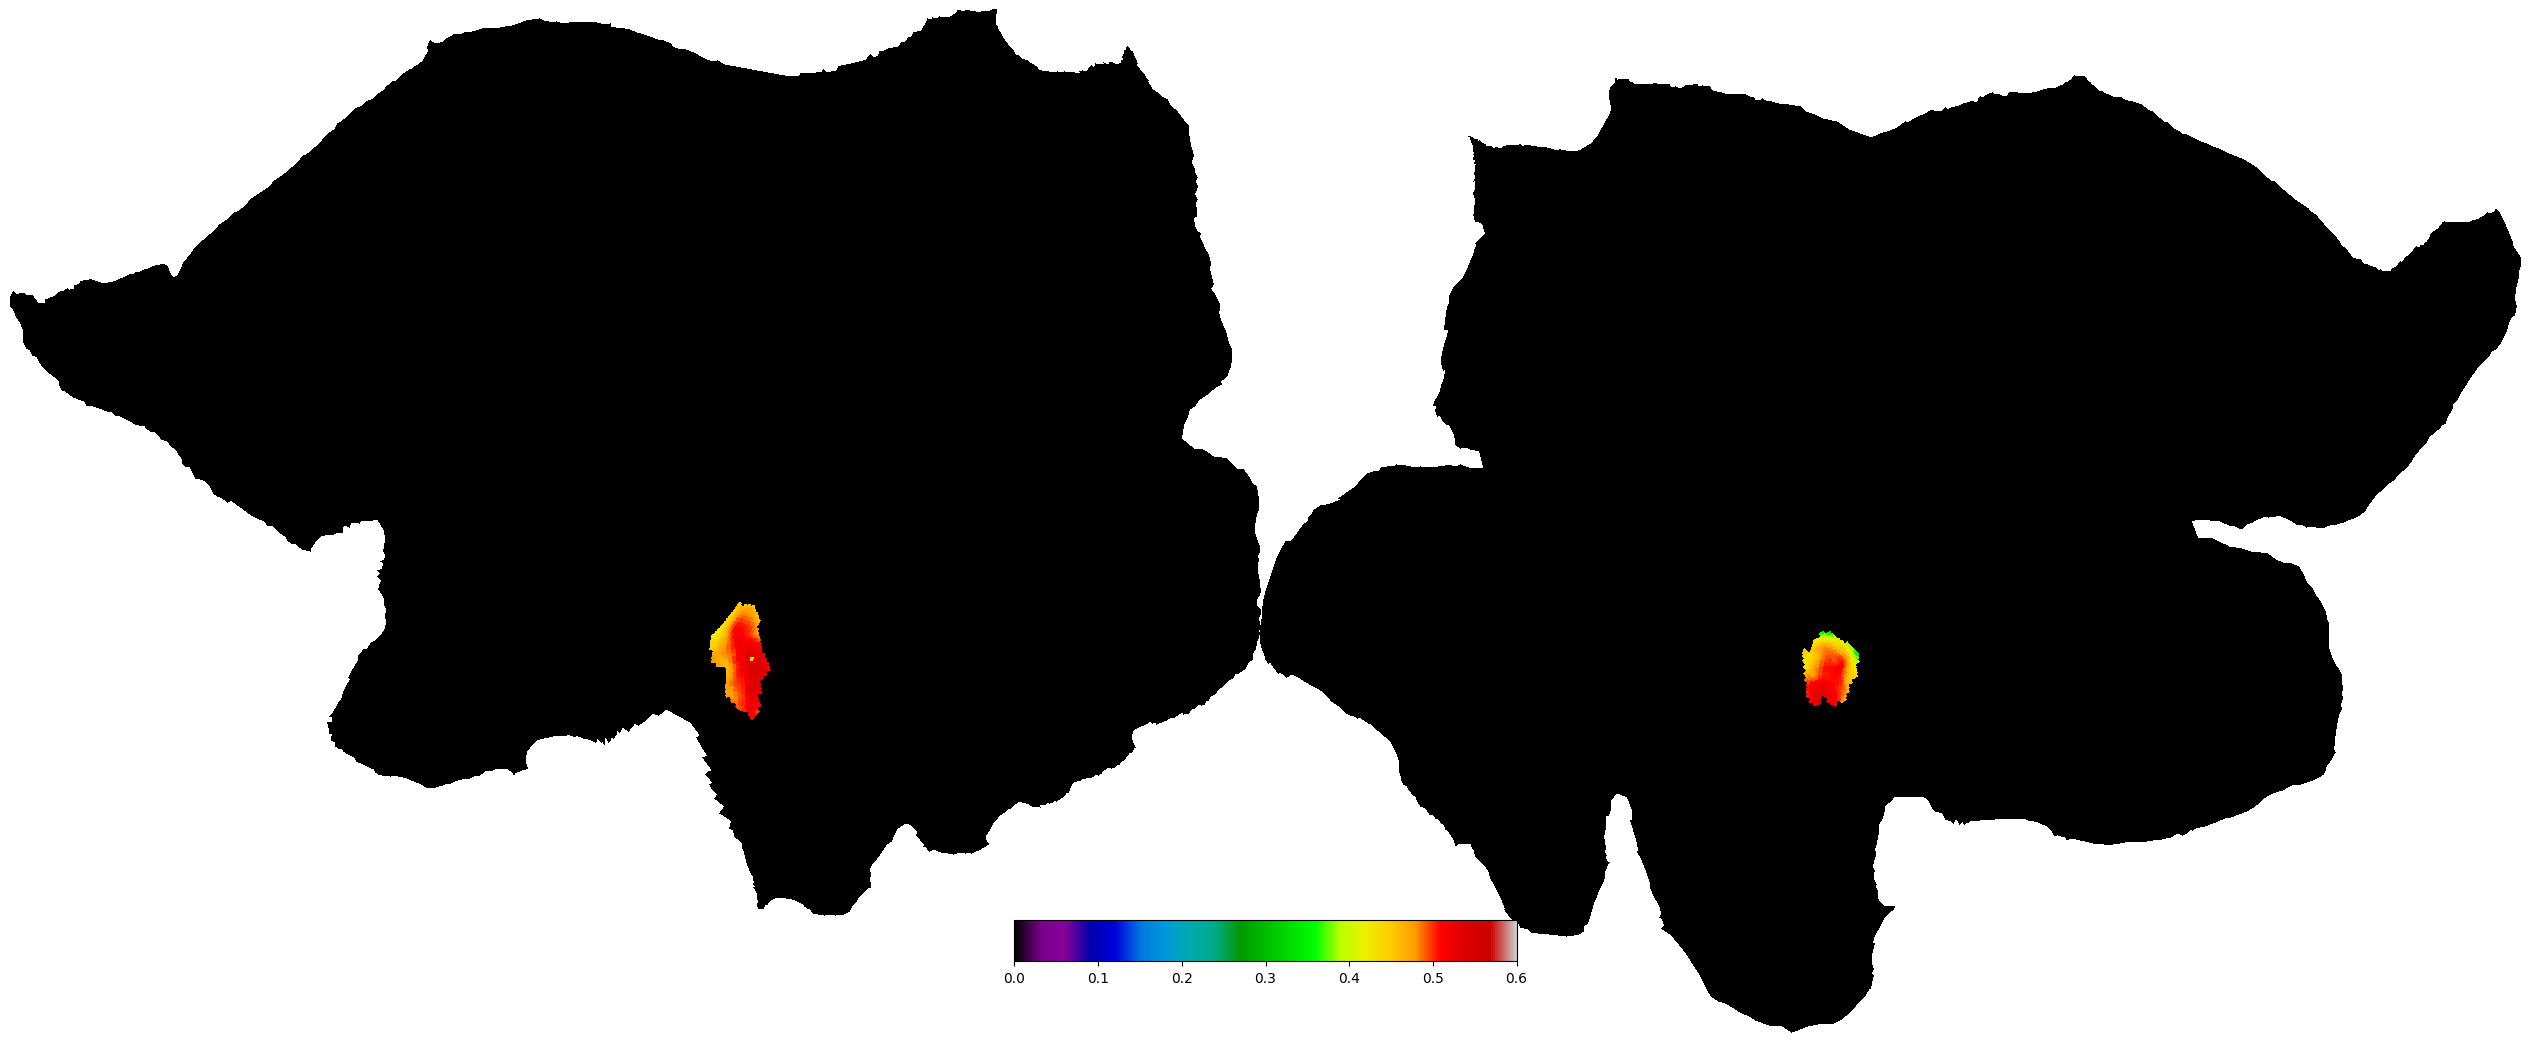

In [13]:
bp=basic_plot(dn['iterative_search_params'][:,-1], colorbar = True, vmax=.6,cmap='nipy_spectral')

### Maps for the parameters of DN model (note: vmin and vmax has been adjusted based on min and max values of the parameters.)

### Mu

In [58]:
print(np.min(dn['iterative_search_params'][:,0]), np.max(dn['iterative_search_params'][:,0]))

0.0 8.464201646310157


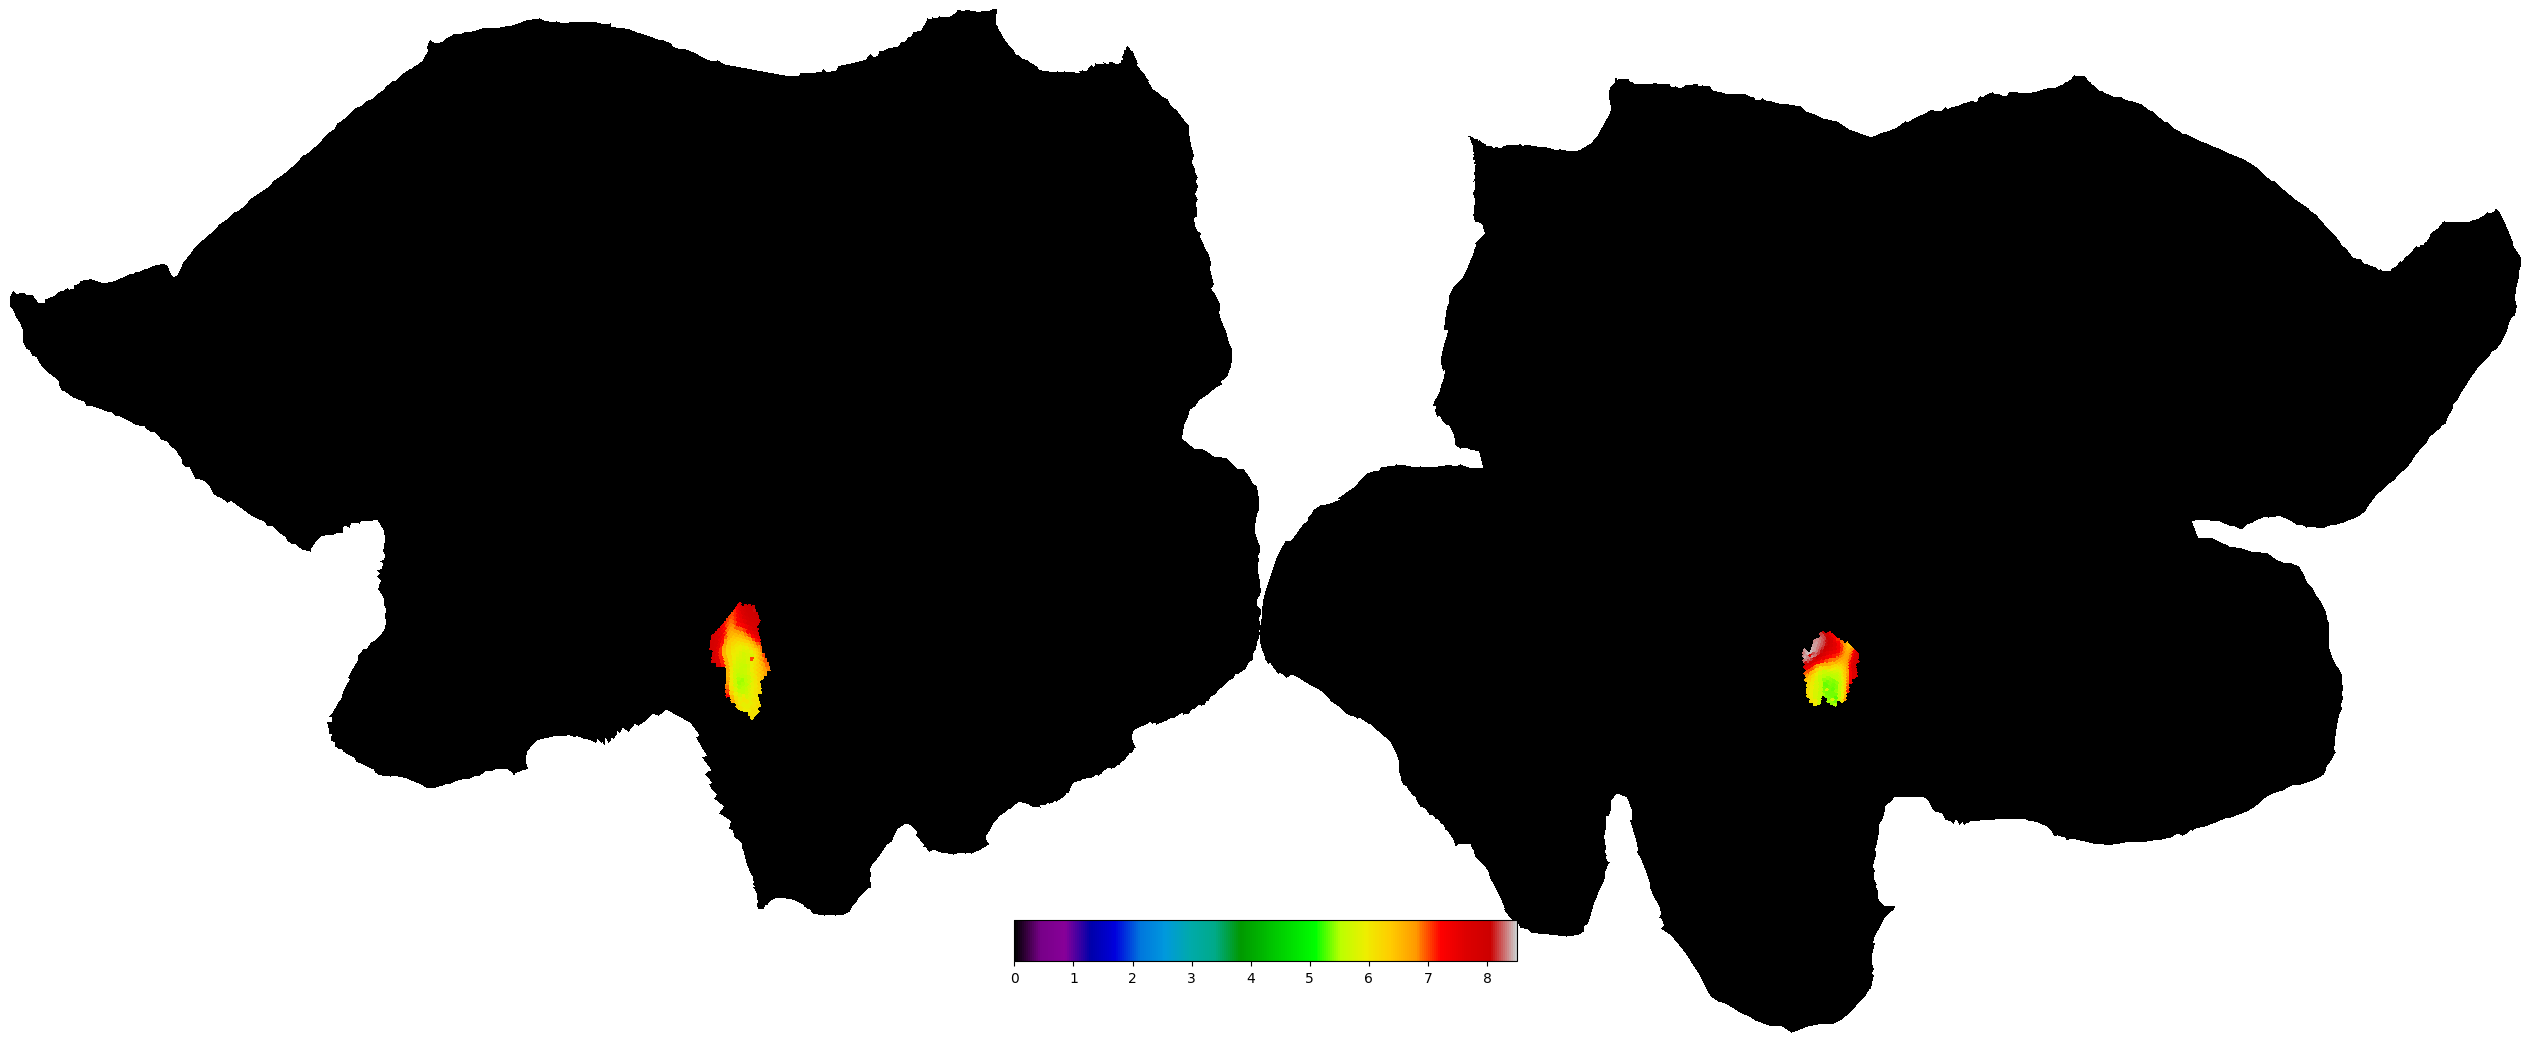

In [18]:
bp=basic_plot(dn['iterative_search_params'][:,0], colorbar = True, vmin=0, vmax=8.5,cmap='nipy_spectral')

### Sigma(Center Size)

In [59]:
print(np.min(dn['iterative_search_params'][:,1]), np.max(dn['iterative_search_params'][:,1]))

0.0 1.3681217997290187


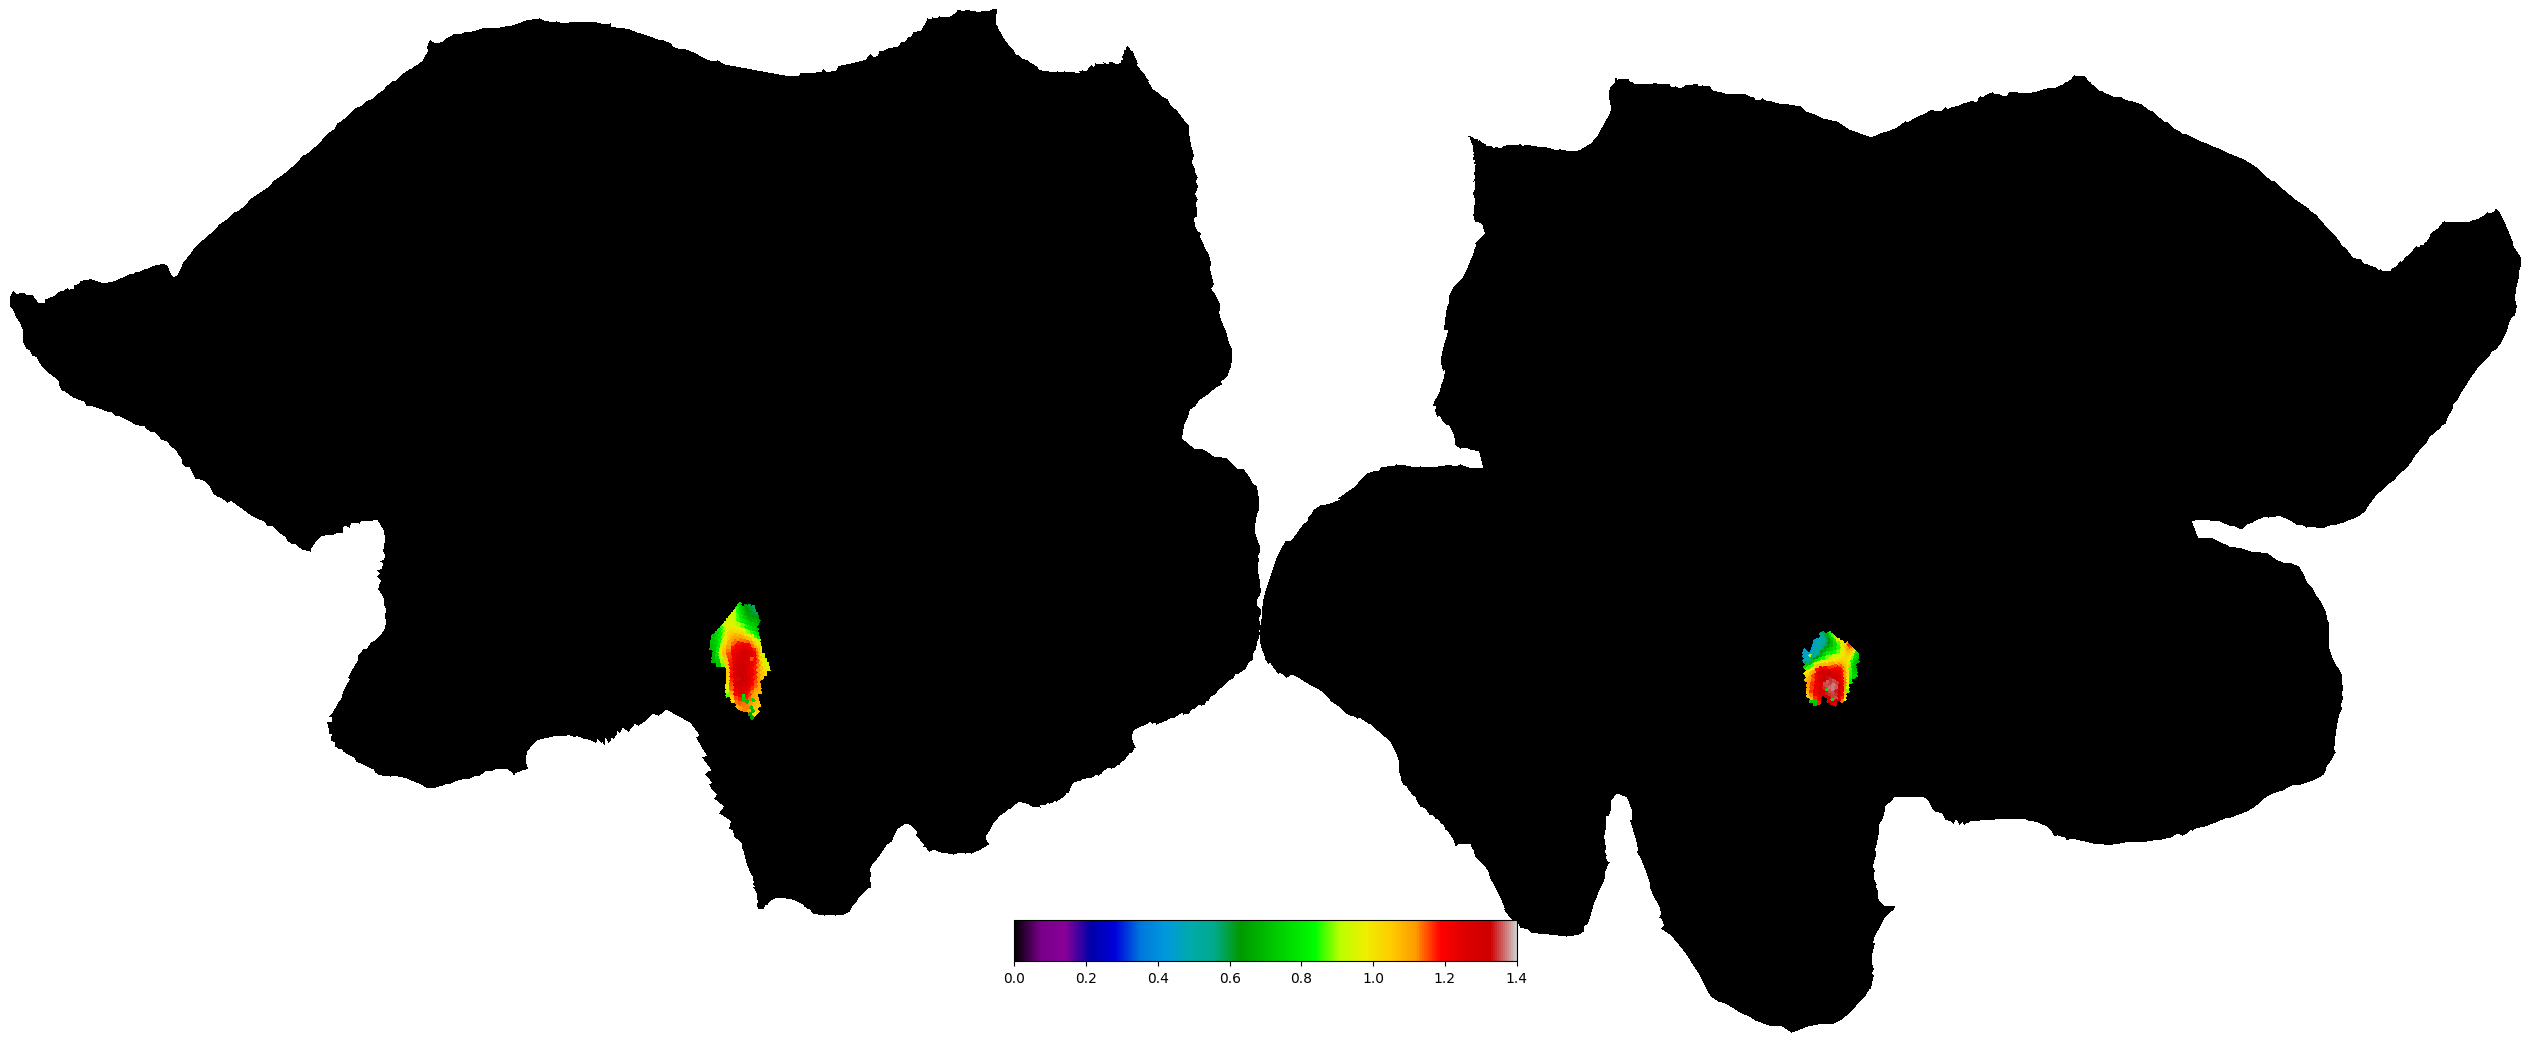

In [20]:
bp=basic_plot(dn['iterative_search_params'][:,1], colorbar = True, vmax=1.4,cmap='nipy_spectral')

### Prf amplitude

In [60]:
print(np.min(dn['iterative_search_params'][:,2]), np.max(dn['iterative_search_params'][:,2]))

0.0 23.90136393286078


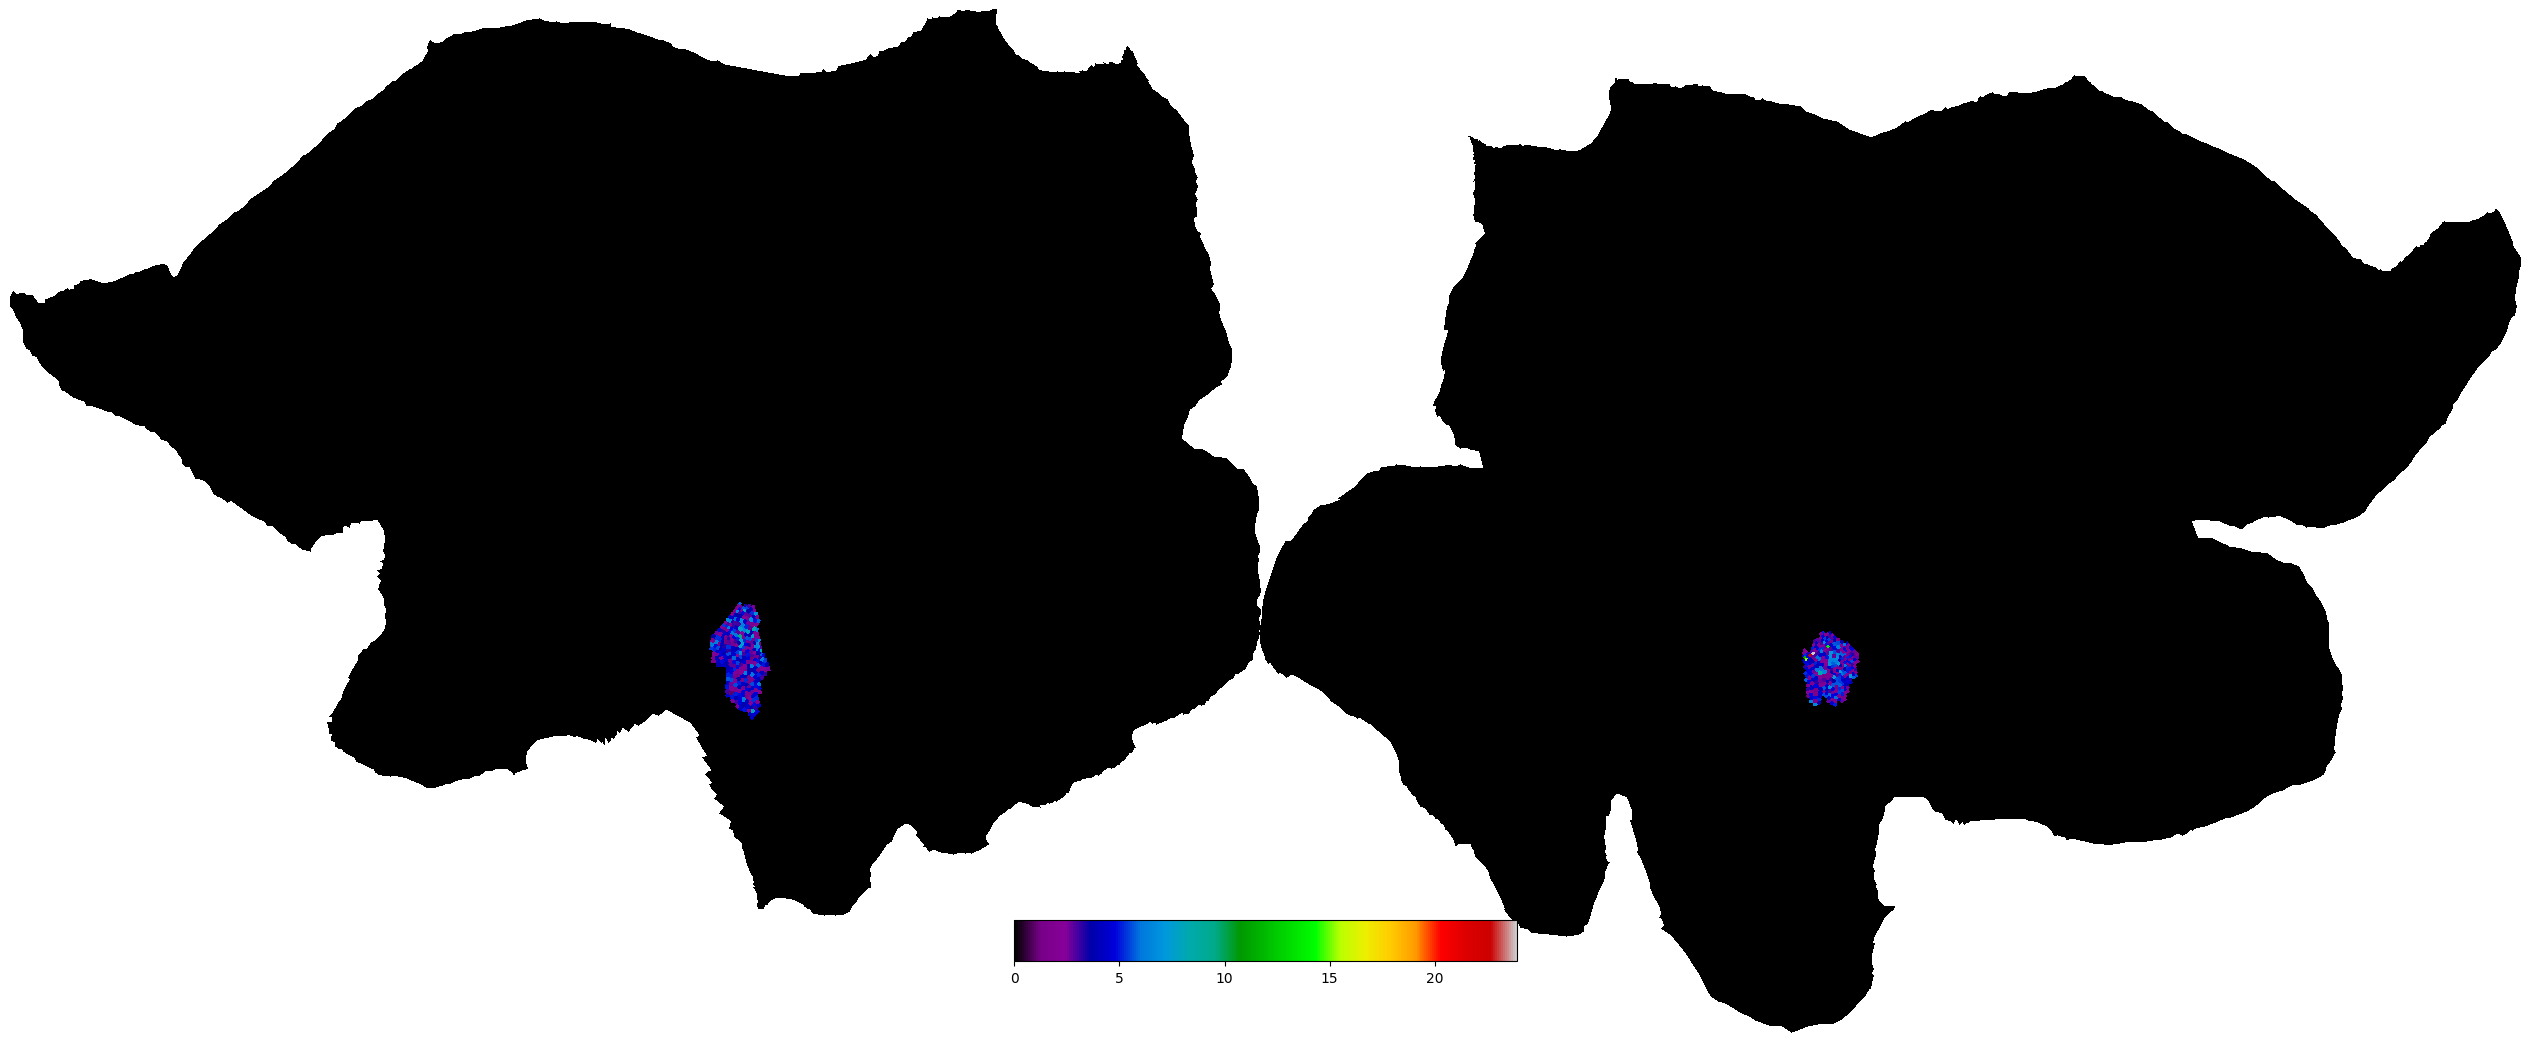

In [22]:
bp=basic_plot(dn['iterative_search_params'][:,2], colorbar = True, vmax=23.9,cmap='nipy_spectral')

### Baseline

In [61]:
print(np.min(dn['iterative_search_params'][:,3]), np.max(dn['iterative_search_params'][:,3]))

-1.2368692744025285 0.0


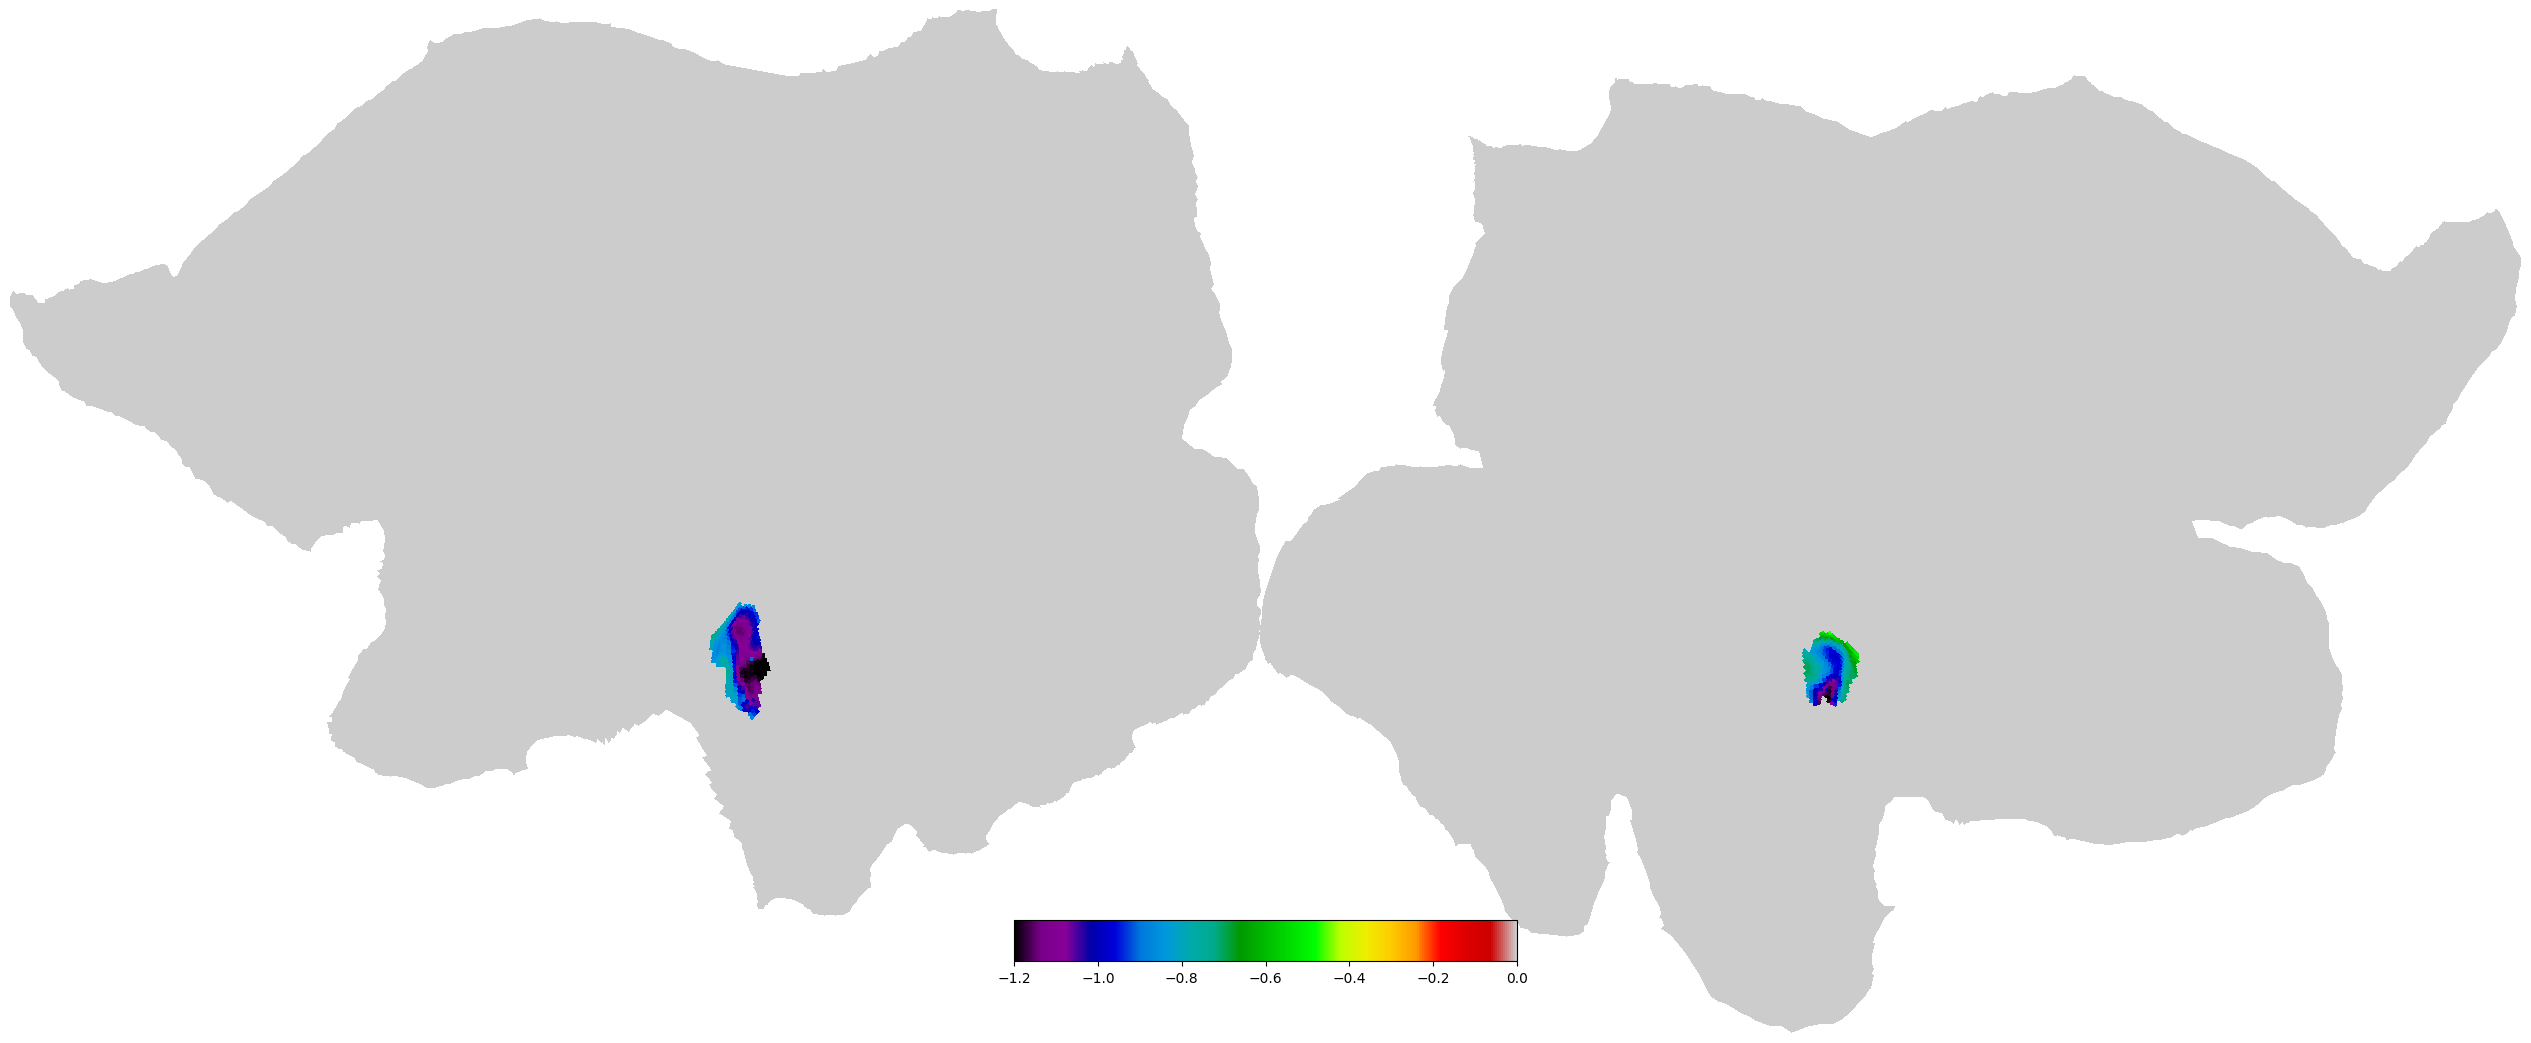

In [29]:
bp=basic_plot(dn['iterative_search_params'][:,3], colorbar = True, vmin=-1.2, vmax=.0,cmap='nipy_spectral')

### Surround amplitude(c)

In [62]:
print(np.min(dn['iterative_search_params'][:,4]), np.max(dn['iterative_search_params'][:,4]))

0.0 2.7245451632172277


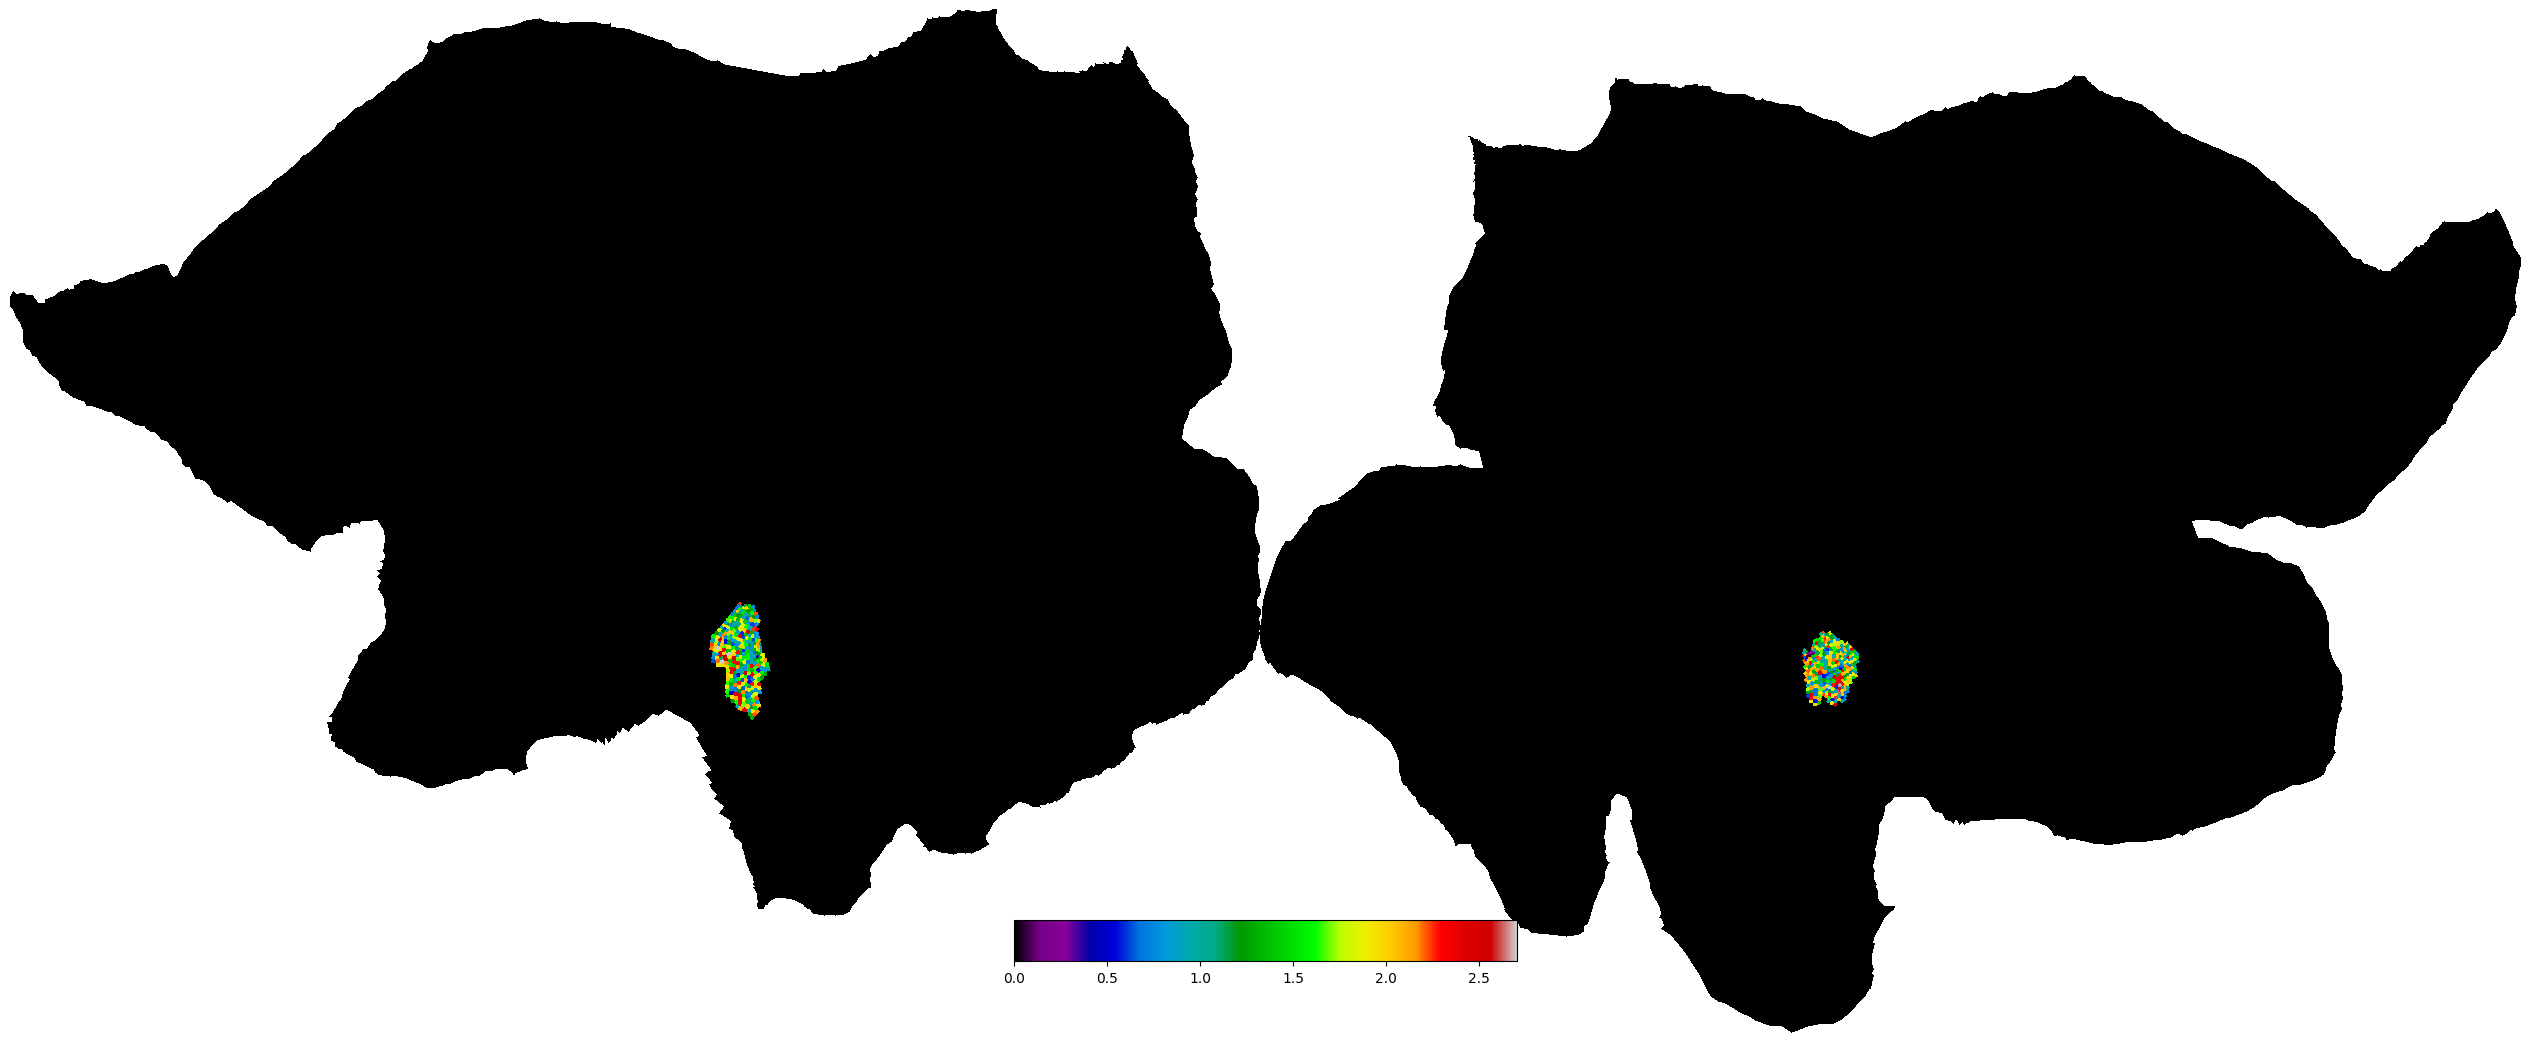

In [30]:
bp=basic_plot(dn['iterative_search_params'][:,4], colorbar = True, vmax=2.7,cmap='nipy_spectral')

### Surround Size(sigma 2)

In [64]:
print(np.min(dn['iterative_search_params'][:,5]), np.max(dn['iterative_search_params'][:,5]))

0.0 2.355094377567505


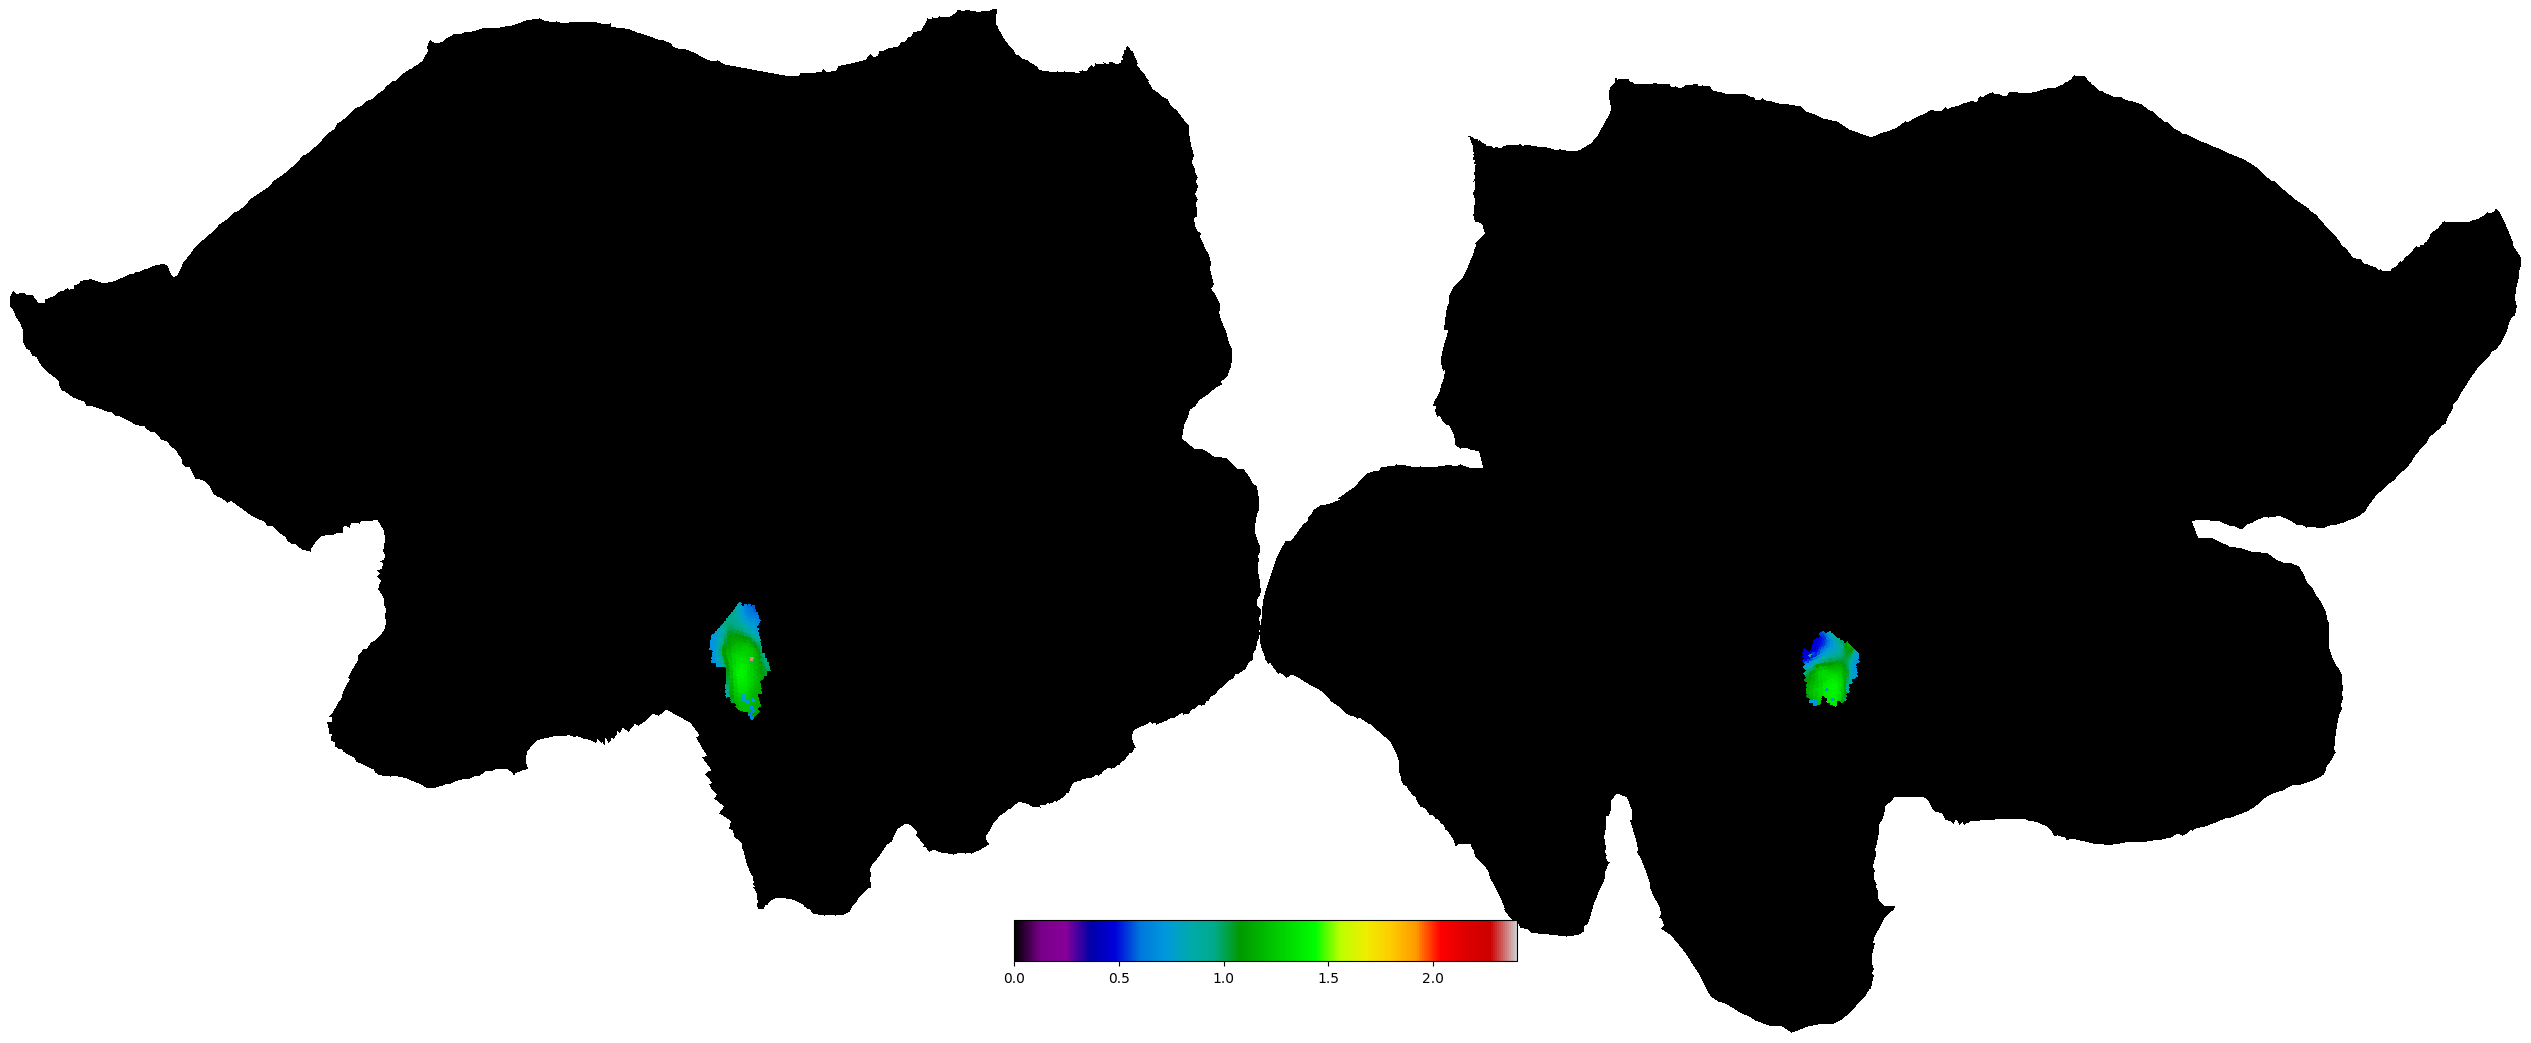

In [31]:
bp=basic_plot(dn['iterative_search_params'][:,5], colorbar = True, vmax=2.4,cmap='nipy_spectral')

### Neural Baseline

In [65]:
print(np.min(dn['iterative_search_params'][:,6]), np.max(dn['iterative_search_params'][:,6]))

0.0 4.541850713052242


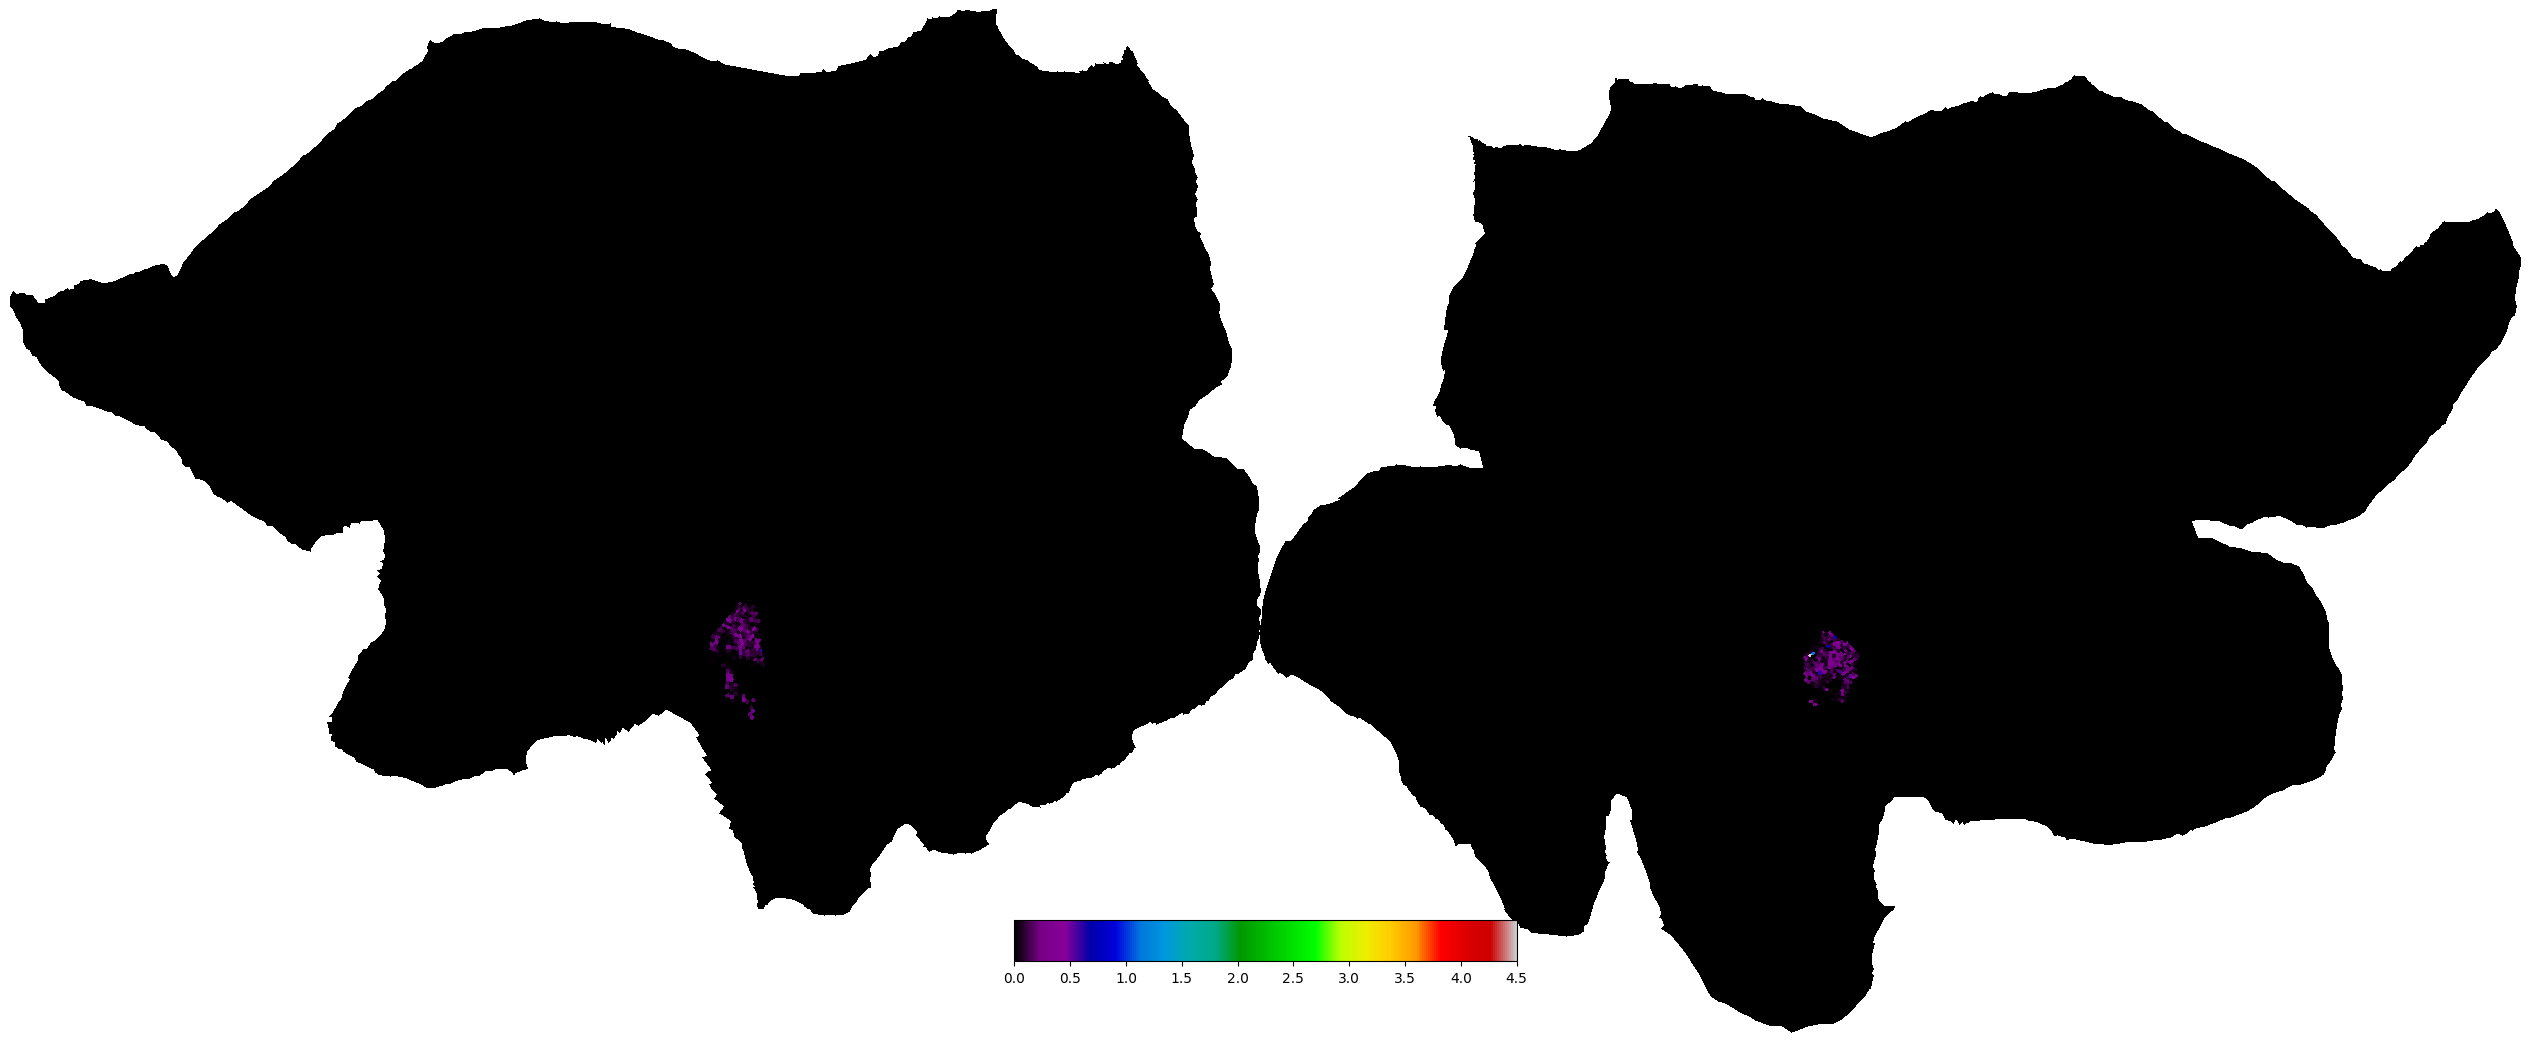

In [38]:
bp=basic_plot(dn['iterative_search_params'][:,6], colorbar = True,vmin=0, vmax=4.5,cmap='nipy_spectral')

### Surround Baseline

In [66]:
print(np.min(dn['iterative_search_params'][:,7]), np.max(dn['iterative_search_params'][:,7]))

-7.948508884832986e-05 0.46827766636506535


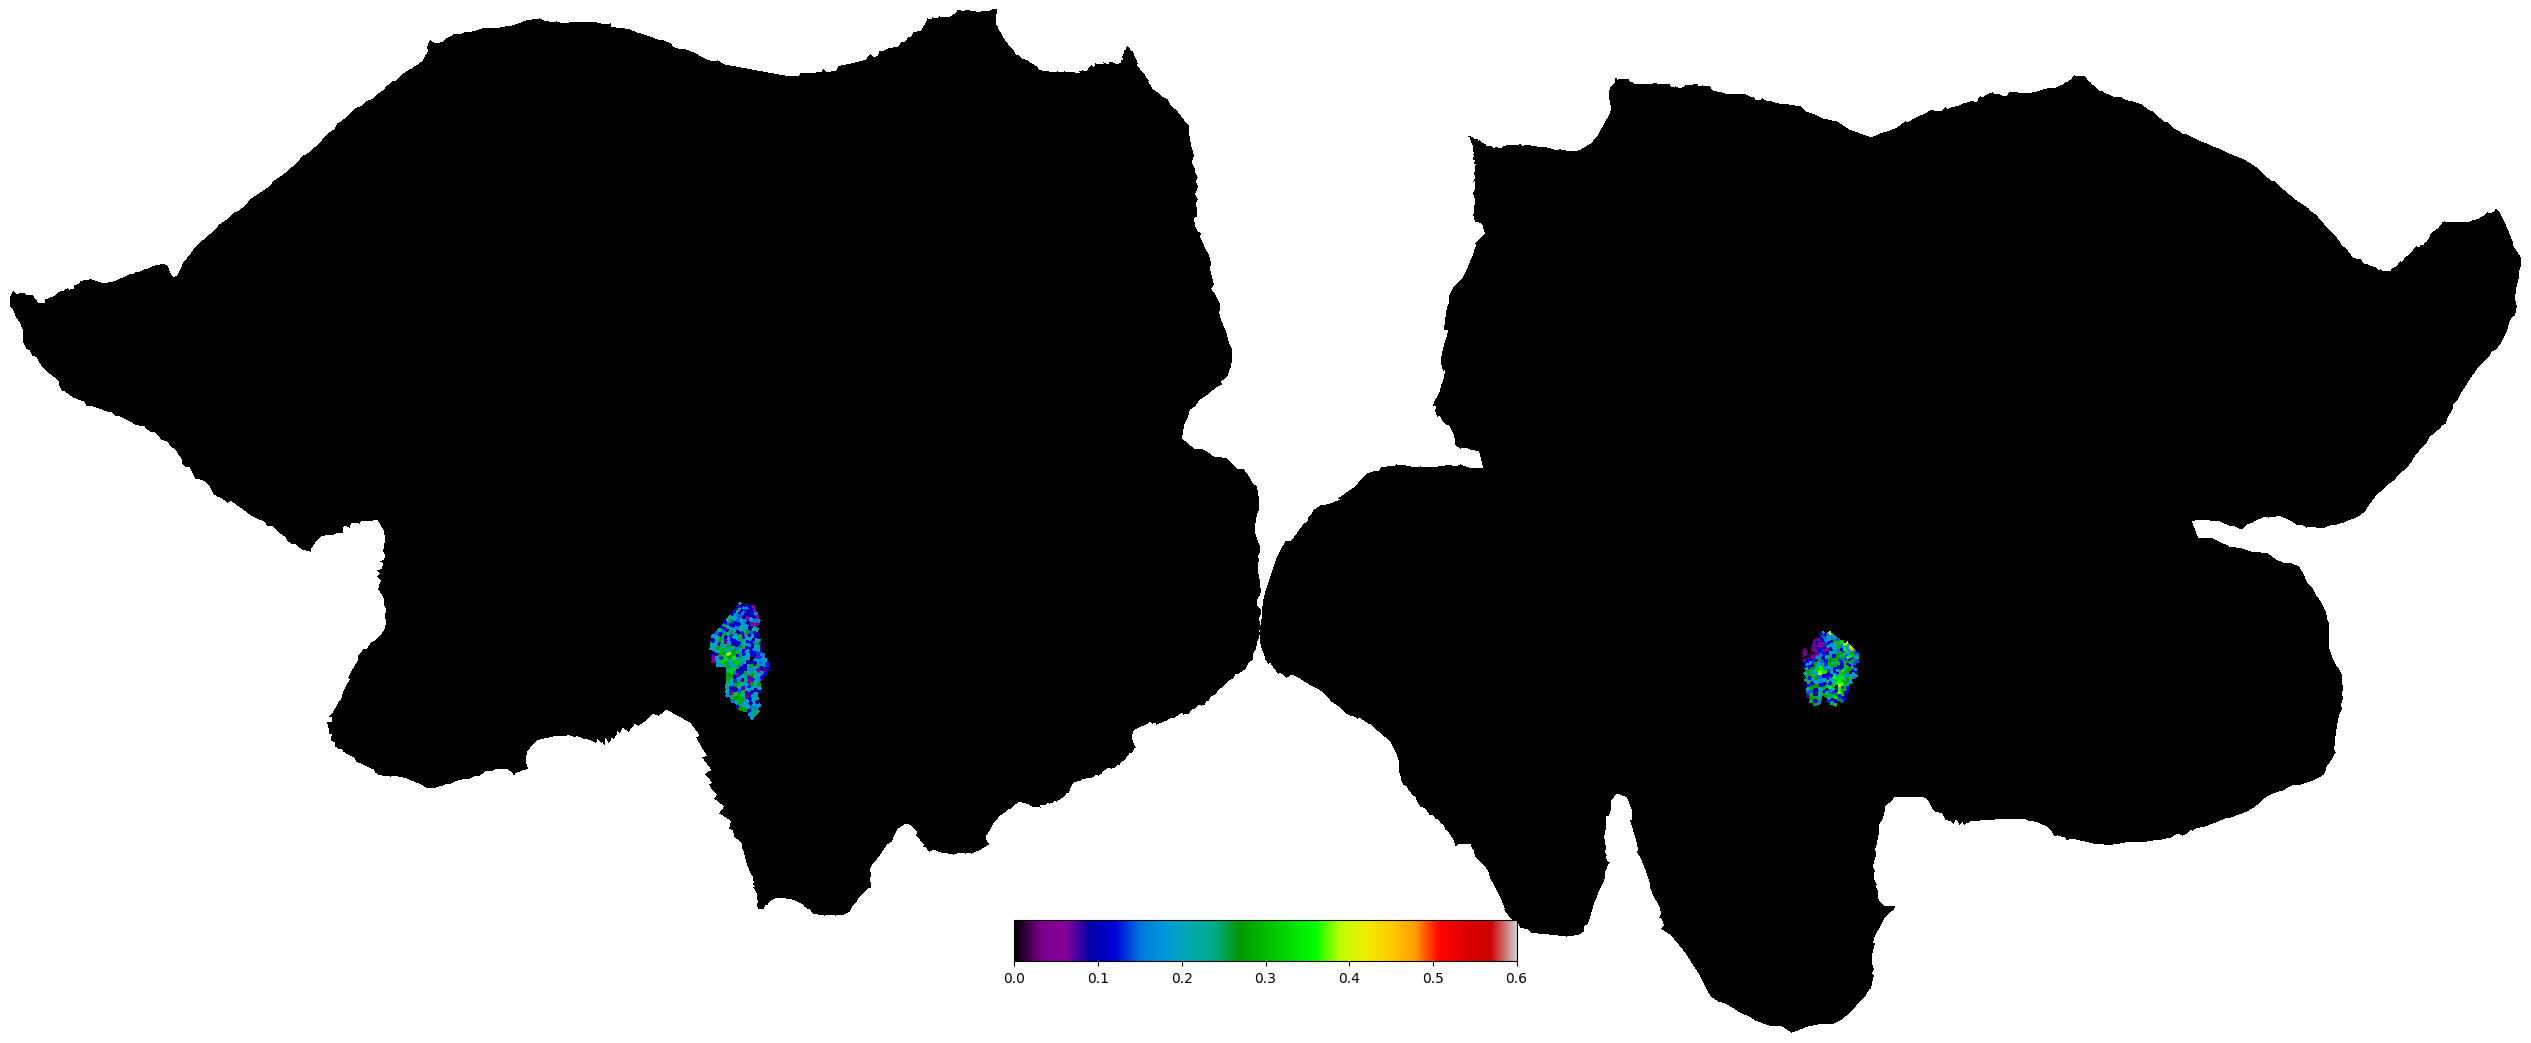

In [36]:
bp=basic_plot(dn['iterative_search_params'][:,7], colorbar = True,vmin=0, vmax=.6,cmap='nipy_spectral')

## Parameter Distributions

In [43]:


import matplotlib.pyplot as plt

r2_difference = Norm_extender.iterative_search_params[:,-1]-css['iterative_search_params'][:,-1]
vmax = np.max(np.abs(r2_difference))

In [68]:
# r2_difference = r2_difference[mask]
print(np.sum(r2_difference>0),np.sum(r2_difference==0),np.sum(r2_difference<0) )

457 117958 169


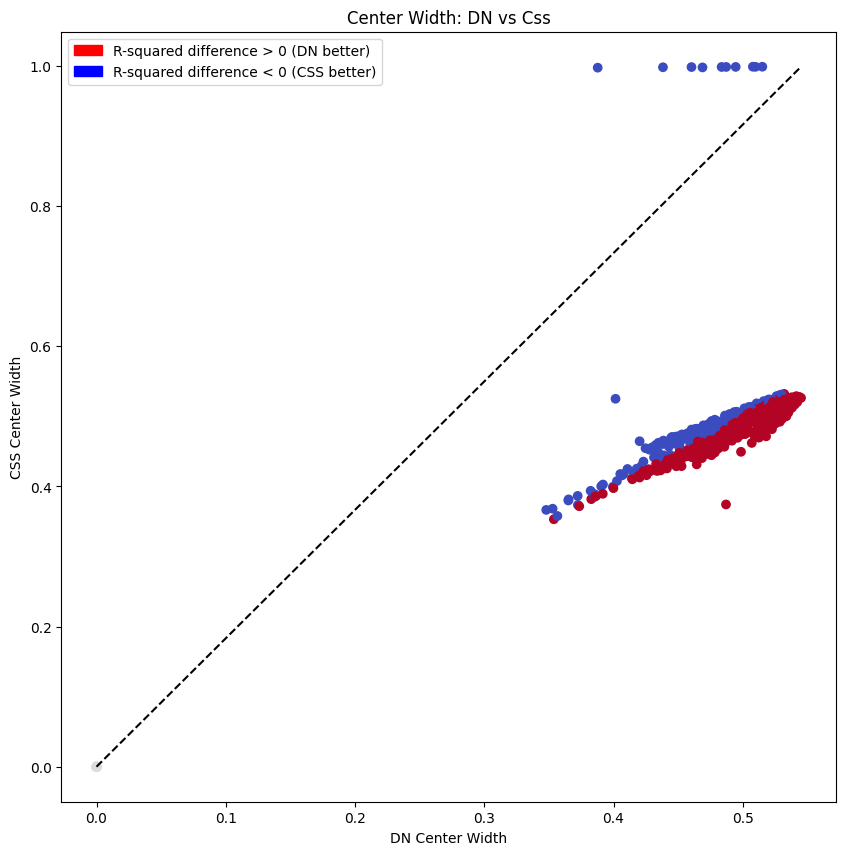

In [45]:
color = np.sign(r2_difference)

plt.figure(figsize=(10, 10))

scatter = plt.scatter(Norm_extender.iterative_search_params[:,-1], css['iterative_search_params'][:,-1], c=color, cmap='coolwarm')

plt.plot([0, max(Norm_extender.iterative_search_params[:,-1])], [0, max(css['iterative_search_params'][:,-1])], 'k--')
plt.xlabel('DN Center Width')
plt.ylabel('CSS Center Width')
plt.title('Center Width: DN vs Css')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='R-squared difference > 0 (DN better)')
blue_patch = mpatches.Patch(color='blue', label='R-squared difference < 0 (CSS better)')

plt.legend(handles=[red_patch, blue_patch])

plt.show()

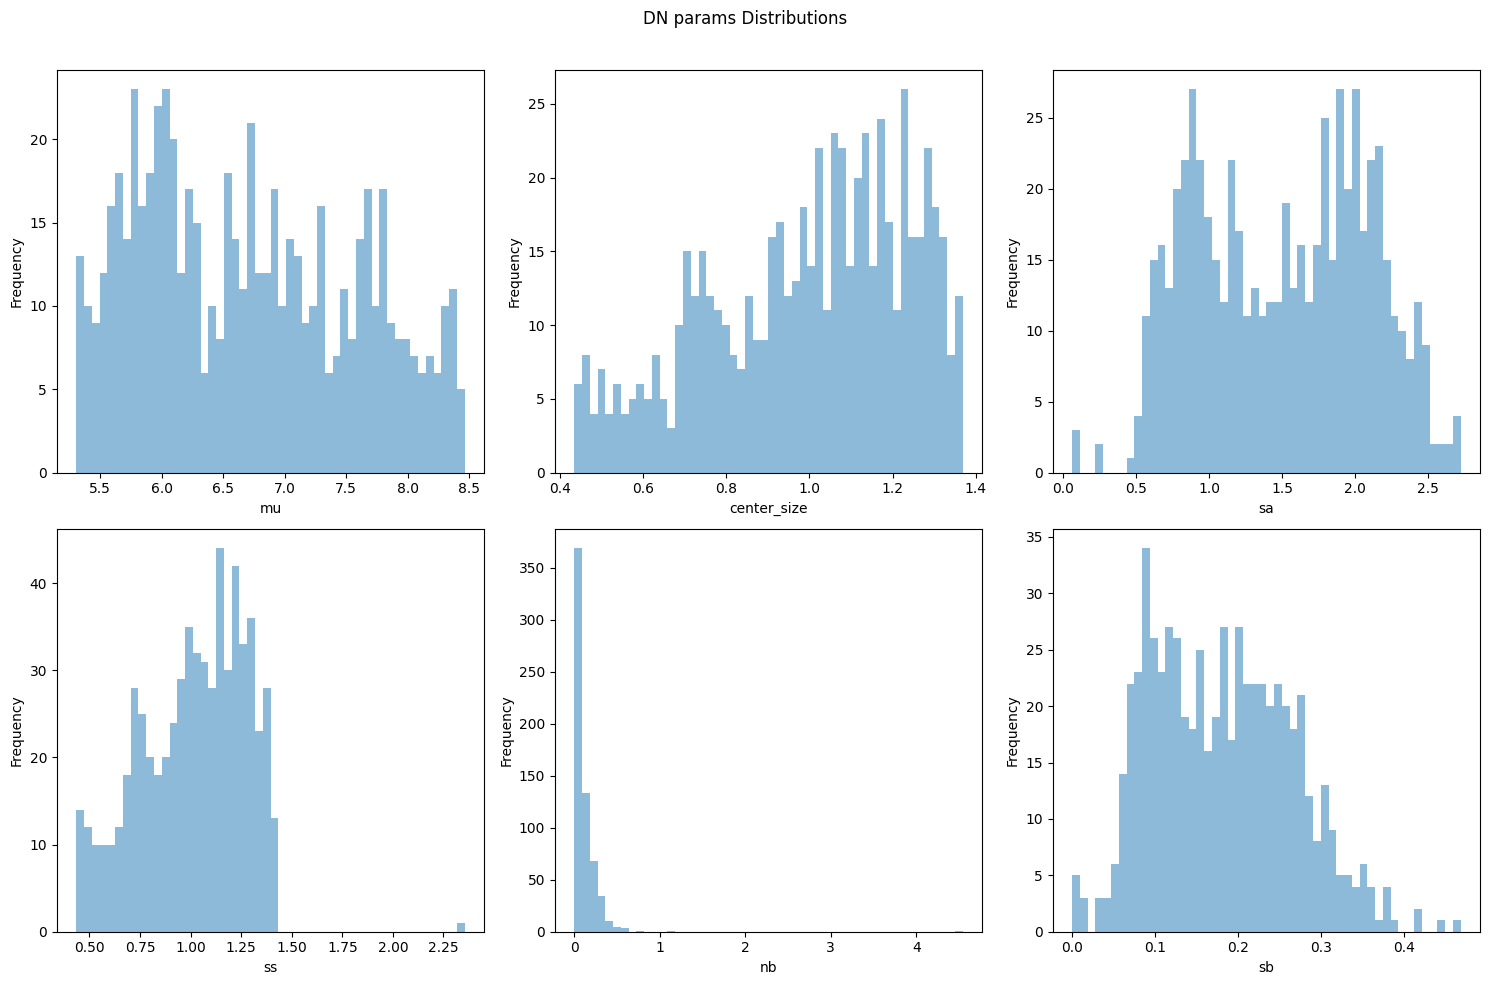

In [67]:
center_size = dn['iterative_search_params'][mask][:, 1]     
mu =  dn['iterative_search_params'][mask][:, 0]  
sa = dn['iterative_search_params'][mask][:, 4] 
ss = dn['iterative_search_params'][mask][:, 5] 
sb = dn['iterative_search_params'][mask][:, 7] 
nb = dn['iterative_search_params'][mask][:,6]


params = [mu, center_size, sa, ss, nb, sb]
labels = ['mu', 'center_size', 'sa', 'ss', 'nb', 'sb']

plt.figure(figsize=(15, 10))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.hist(params[i], bins=50, alpha=0.5)
    plt.xlabel(labels[i])
    plt.ylabel('Frequency')

plt.suptitle('DN params Distributions')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

##### Here we can see that the SS still converges to values less than 1.5 even though the starting grid parameters given were : [ 2.5449028,  3.5628638,  4.580825 ,  5.598786 ,  6.616747 , 7.6347084,  8.652669 ,  9.67063  , 10.688591 , 11.7065525, 12.724514 ].